# Projet 4

**Énoncé**

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

**Les données**

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Voici les [données](https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/2016_Building_Energy_Benchmarking.csv) et [leur source](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy). Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

**Mission**

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

Réaliser une courte analyse exploratoire.
Tester différents modèles de prédiction afin de répondre au mieux à la problématique.
Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes et erreurs à éviter :



Douglas : L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées.. 

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.

**Livrables attendus**

Un **notebook de l'analyse exploratoire** mis au propre et annoté.

Un **notebook pour chaque prédiction** (émissions de CO2 et consommation totale d’énergie) des différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi.

Un **support de présentation** pour la soutenance (entre 15 et 25 slides).

**But du projet :**

Le but du projet est de : prédire les émissions de CO2 **target 2: TotalGHGEmissions**

prédire la consommation totale d’énergie de bâtiments **target 1: SiteEnergyUse_kBtu**


# Notebook de nettoyage

In [1]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
import matplotlib as mpl
import sys
import IPython as ip
import sklearn
import datetime
import re
import missingno as msno
from termcolor import colored

from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Binarizer
from sklearn.ensemble import RandomForestRegressor

from yellowbrick.model_selection import FeatureImportances



from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')




# 1. Importation et découverte des données 

In [2]:
data = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

In [3]:
#grader une copie du dataframe
df_building=data.copy()

In [4]:
data.head(5)

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
0                    0659000030  ...      1.156514e+06         3946027.0   
1                    0659000220  ...      9.504252e+05         3242851.0   
2                    0659000475  ...      1.451544e+07        49526664.0   
3                    0659000640  ...      8.115253e+05         2768924.0   
4                    0659000970  ...      1.573449e+06         5368607.0   

   NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
0         12764.52930         1276453.0        False       NaN   
1         51450.81641         5145082.0        False       NaN   
2         14938.00000         1493800.0        False       NaN   
3         18112.13086         1811213.0        False       NaN   
4         88039.98438         8803998.0        False       NaN   

   ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
0         Compliant      NaN             249.98                   2.83  
1         Compliant      NaN             295.86                   2.86  
2         Compliant      NaN            2089.28                   2.19  
3         Compliant      NaN             286.43                   4.67  
4         Compliant      NaN             505.01                   2.88  

[5 rows x 46 columns]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [6]:
data.describe()

OSEBuildingID  DataYear       ZipCode  CouncilDistrictCode  \
count    3376.000000    3376.0   3360.000000          3376.000000   
mean    21208.991114    2016.0  98116.949107             4.439277   
std     12223.757015       0.0     18.615205             2.120625   
min         1.000000    2016.0  98006.000000             1.000000   
25%     19990.750000    2016.0  98105.000000             3.000000   
50%     23112.000000    2016.0  98115.000000             4.000000   
75%     25994.250000    2016.0  98122.000000             7.000000   
max     50226.000000    2016.0  98272.000000             7.000000   

          Latitude    Longitude    YearBuilt  NumberofBuildings  \
count  3376.000000  3376.000000  3376.000000        3368.000000   
mean     47.624033  -122.334795  1968.573164           1.106888   
std       0.047758     0.027203    33.088156           2.108402   
min      47.499170  -122.414250  1900.000000           0.000000   
25%      47.599860  -122.350662  1948.000000           1.000000   
50%      47.618675  -122.332495  1975.000000           1.000000   
75%      47.657115  -122.319407  1997.000000           1.000000   
max      47.733870  -122.220966  2015.000000         111.000000   

       NumberofFloors  PropertyGFATotal  ...  SiteEnergyUse(kBtu)  \
count     3376.000000      3.376000e+03  ...         3.371000e+03   
mean         4.709123      9.483354e+04  ...         5.403667e+06   
std          5.494465      2.188376e+05  ...         2.161063e+07   
min          0.000000      1.128500e+04  ...         0.000000e+00   
25%          2.000000      2.848700e+04  ...         9.251286e+05   
50%          4.000000      4.417500e+04  ...         1.803753e+06   
75%          5.000000      9.099200e+04  ...         4.222455e+06   
max         99.000000      9.320156e+06  ...         8.739237e+08   

       SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
count           3.370000e+03    3.367000e+03      3.367000e+03   
mean            5.276726e+06    2.745959e+05      1.086639e+06   
std             1.593879e+07    3.912173e+06      4.352478e+06   
min             0.000000e+00    0.000000e+00     -3.382680e+04   
25%             9.701822e+05    0.000000e+00      1.874229e+05   
50%             1.904452e+06    0.000000e+00      3.451299e+05   
75%             4.381429e+06    0.000000e+00      8.293178e+05   
max             4.716139e+08    1.349435e+08      1.925775e+08   

       Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  Comments  \
count       3.367000e+03        3.367000e+03      3.367000e+03       0.0   
mean        3.707612e+06        1.368505e+04      1.368505e+06       NaN   
std         1.485066e+07        6.709781e+04      6.709781e+06       NaN   
min        -1.154170e+05        0.000000e+00      0.000000e+00       NaN   
25%         6.394870e+05        0.000000e+00      0.000000e+00       NaN   
50%         1.177583e+06        3.237538e+03      3.237540e+05       NaN   
75%         2.829632e+06        1.189033e+04      1.189034e+06       NaN   
max         6.570744e+08        2.979090e+06      2.979090e+08       NaN   

       TotalGHGEmissions  GHGEmissionsIntensity  
count        3367.000000            3367.000000  
mean          119.723971               1.175916  
std           538.832227               1.821452  
min            -0.800000              -0.020000  
25%             9.495000               0.210000  
50%            33.920000               0.610000  
75%            93.940000               1.370000  
max         16870.980000              34.090000  

[8 rows x 30 columns]

In [7]:
print('1 ------------------------------------------------------------------------')
print ('Il y a ', data.shape[0], 'lignes et ', data.shape[1],'colonnes dans la base ')
# données manquantes par colonnes
print('2 ------------------------------------------------------------------------')
print('Le nombre de données manquantes par colonnes : \n',data.isna().sum())
# données manquantes dans toute la base
print('3 ------------------------------------------------------------------------')
print('Le nombre total de données manquantes est : \n',data.isna().sum().sum())
# pourcentage des données manquantes 
print('4 ------------------------------------------------------------------------')
print('Le pourcentage des données manquantes est : \n',round(data.isna().mean().mean()*100,2),'%')
# nombre de doublons sur toutes les colonnes
if data.duplicated().unique():
    print ('Il y a ', data.duplicated().sum(), 'lignes dupliquées')
else:
    print('Il n\'y a pas de doublons dans cette base')

1 ------------------------------------------------------------------------
Il y a  3376 lignes et  46 colonnes dans la base 
2 ------------------------------------------------------------------------
Le nombre de données manquantes par colonnes : 
 OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     8
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking             

In [8]:
# liste des colonnes
listCol = data.columns.tolist()
listCol

['OSEBuildingID',
 'DataYear',
 'BuildingType',
 'PrimaryPropertyType',
 'PropertyName',
 'Address',
 'City',
 'State',
 'ZipCode',
 'TaxParcelIdentificationNumber',
 'CouncilDistrictCode',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'YearsENERGYSTARCertified',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'DefaultData',
 'Comments',
 'ComplianceStatus',
 'Outlier',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity']

In [9]:
# remplacer les caracteres '(','/' par '_' dans les noms de colonnes
data.columns = data.columns.str.replace("[(/]", "_")
# remplacer les caracteres ')' par '' dans les noms de colonnes
data.columns = data.columns.str.replace("[)]", "")


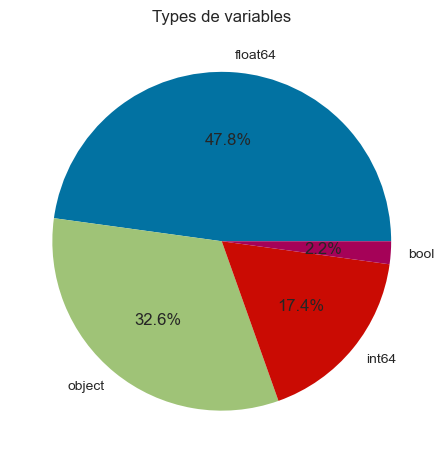

In [10]:
# Pie plot types de colonnes
data.dtypes.value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Types de variables')
plt.ylabel('')
fichier ='pieplot_type_variable'+'.png'
plt.savefig(fichier)
plt.show()

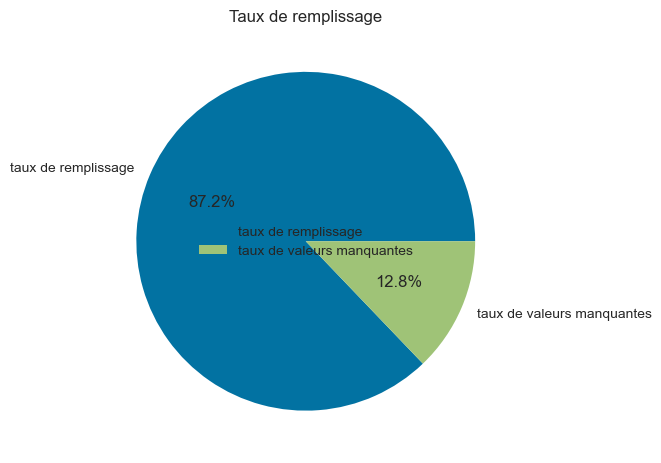

In [11]:
# Pie plot taux de remplissage du jeu de données
pd.DataFrame({'remplissage':[data.notna().mean().mean(),data.isna().mean().mean()]},index=['taux de remplissage','taux de valeurs manquantes']).plot.pie(autopct='%1.1f%%',subplots=True)
plt.title('Taux de remplissage')
plt.ylabel('')
plt.legend(loc='center')
fichier ='pieplot_remplissage'+'.png'
plt.savefig(fichier)
plt.show()


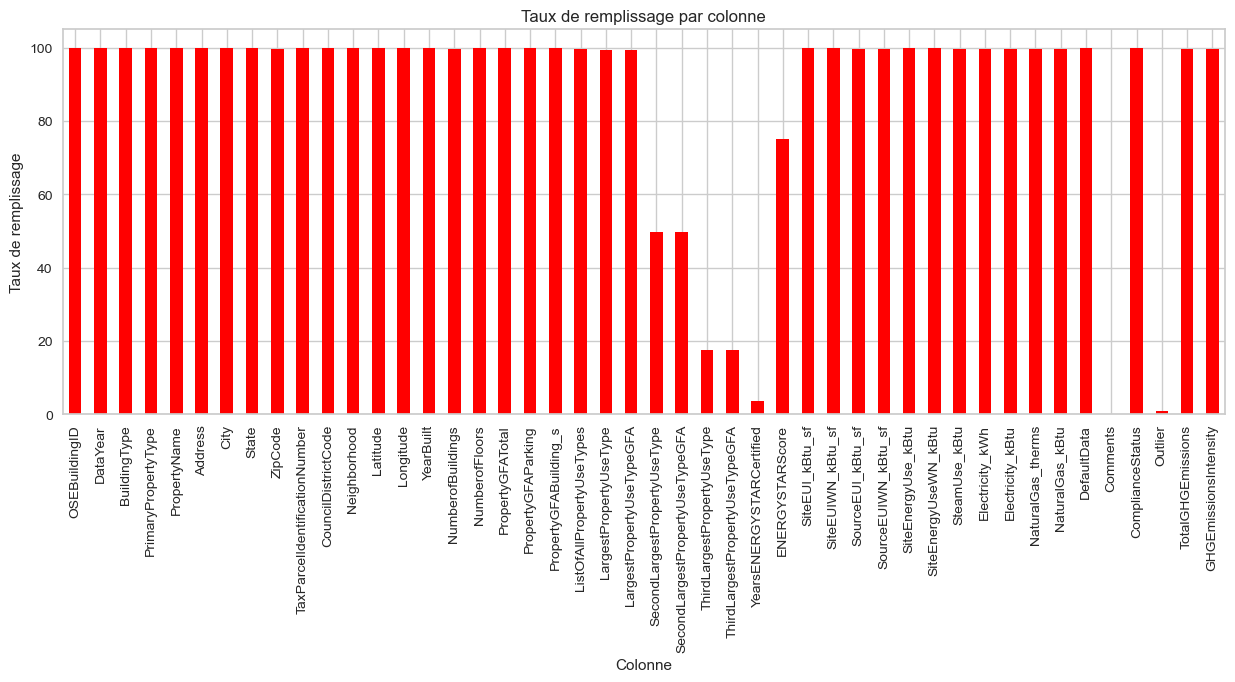

In [12]:
# Calcul du taux de remplissage  par colonne

plt.figure(figsize=(15, 5))
G = gridspec.GridSpec(1, 1)

ax = plt.subplot(G[0, :])
taux_remplissage = 100-data.isna().mean()*100
ax = taux_remplissage.plot(kind='bar', color='red')
ax.set_title('Taux de remplissage par colonne')
ax.set_xlabel('Colonne')
ax.set_ylabel('Taux de remplissage')
ax.grid(True)
fichier ='taux_remplissage'+'.png'
plt.savefig(fichier)
plt.show()

In [13]:
data.shape

(3376, 46)

# 2. Analyse de fond

## Supprimer les lignes vides

In [14]:
# supprimer les lignes ne contenant que des informations générales 
data.iloc[:,8:].dropna(how='all', axis=0, inplace=True)
data.shape

(3376, 46)

## Supprimer les lignes dupliquées

In [15]:
# supprimer les doublons
data.drop_duplicates(inplace=True)
print ('Il y a ', data.shape[0], 'lignes et ', data.shape[1],'colonnes dans la base ')

Il y a  3376 lignes et  46 colonnes dans la base 


## Répartition de la consomation  d'énergie dans la ville 

In [16]:
import plotly.express as px

fig = px.scatter_mapbox(data, lat="Latitude", lon="Longitude", hover_name="PropertyName", color = "SiteEnergyUse_kBtu"
                       ,color_continuous_scale="viridis", zoom = 10, title= "Répartition de la consomation  en énergie des bâtiments dans la ville de Seattle" )
fig.update_layout(mapbox_style="open-street-map")
#fig.update_layout(title = "Répartition de la consomation  en énergie des bâtiments dans la ville de Seattle" )
fig.update_layout(margin={"r":0,"l":0,"b":0})
fig.show()

In [17]:
import folium
import folium.plugins

#Coordonnées du centre de Seattle
seattle_lat = 47.6062
seattle_lon = -122.3321

seattle = folium.Map(location=[seattle_lat, seattle_lon], zoom_start=12)

#Clusters
marker_cluster = folium.plugins.MarkerCluster().add_to(seattle)
for lat, lon, in zip(data.Latitude, data.Longitude):
    folium.Marker(location=[lat, lon]).add_to(marker_cluster)

seattle

## Sélection et traitement des colonnes utiles

Une première vérification des variables nous mène à supprimer quelques colonnes inutiles

In [18]:

colonnes_a_supprimer = ['OSEBuildingID', # identifiant unique 
                        'PropertyName',# n'apporte pas d'information, comme une variable id
                        'City',# seule ville  (Seattle)
                        'State', # même Etat (Washington)
                        'ZipCode', # garder latitude et longitude
                        'YearsENERGYSTARCertified', # information inutile (Années pendant lesquelles la propriété a reçu la certification ENERGY STAR)
                        'TaxParcelIdentificationNumber', #information fiscale inutile
                        'CouncilDistrictCode', # information inutile (code de conseil municipal)
                        'ListOfAllPropertyUseTypes', #plusieurs valeurs qui sont contenues dans les autres colonnes
                        'Outlier', #plusieurs valeurs nulles
                        'Comments' ]# aucune valeur



**Nouvelle variable 'Building_Age'**

In [19]:
# A partir de la difference des deux variable "DataYear" et "YearBuilt"
data["Building_Age"] = data["DataYear"] - data["YearBuilt"]
data[["Building_Age", "DataYear", "YearBuilt"]].head()

Building_Age  DataYear  YearBuilt
0            89      2016       1927
1            20      2016       1996
2            47      2016       1969
3            90      2016       1926
4            36      2016       1980

In [20]:
# Supprimer les deux variables "DataYear"et "YearBuilt"
for col in ["YearBuilt","DataYear"]:
  colonnes_a_supprimer.append(col)


**Variable 'NumberofBuildings'**

In [21]:
def val_colonne(colonne):
  print('nbre_valeurs : ',data[colonne].nunique())
  if data[colonne].dtypes!='object':
    print('Liste_valeurs : ',sorted(data[colonne].unique().tolist()))
  else:
    print('Liste_valeurs : ',data[colonne].unique().tolist())


In [22]:
val_colonne('NumberofBuildings')

nbre_valeurs :  17
Liste_valeurs :  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 14.0, 27.0, nan, 16.0, 23.0, 111.0]


La valeur 0 est une valeur aberrante, remplacer par 1

La valeur 111 correspond à une université (google maps) donc c'est une valeur possible

In [23]:
data.loc[data['NumberofBuildings'] == 0.0,'NumberofBuildings'] = 1 

**Variable 'NumberofFloors'**

In [24]:
val_colonne('NumberofFloors')

nbre_valeurs :  50
Liste_valeurs :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 46, 47, 49, 55, 56, 63, 76, 99]


La valeur 0 est une valeur aberrante, remplacer par 1

In [25]:
data.loc[data['NumberofFloors'] == 0.0,'NumberofFloors'] = 1 

**Variable 'Neighborhood'**

In [26]:
val_colonne('Neighborhood')

nbre_valeurs :  19
Liste_valeurs :  ['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'Central', 'NORTH', 'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH', 'BALLARD', 'NORTHWEST', 'CENTRAL', 'SOUTHWEST', 'DELRIDGE', 'Ballard', 'North', 'Delridge', 'Northwest', 'DELRIDGE NEIGHBORHOODS']


In [27]:
# minuscule et majuscule, transformer toutes les valeurs en majuscule
data['Neighborhood'] = data['Neighborhood'].apply(lambda x: x.upper().strip())

**Variables 'PrimaryPropertyType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType' et 'LargestPropertyUseType'**

In [28]:
colonne_a_traiter = ['PrimaryPropertyType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType','LargestPropertyUseType']
for col in colonne_a_traiter:
  val_colonne(col)

nbre_valeurs :  24
Liste_valeurs :  ['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property', 'K-12 School', 'University', 'Small- and Mid-Sized Office', 'Self-Storage Facility', 'Warehouse', 'Large Office', 'Senior Care Community', 'Medical Office', 'Retail Store', 'Hospital', 'Residence Hall', 'Distribution Center', 'Worship Facility', 'Low-Rise Multifamily', 'Supermarket / Grocery Store', 'Laboratory', 'Refrigerated Warehouse', 'Restaurant', 'High-Rise Multifamily', 'Office']
nbre_valeurs :  50
Liste_valeurs :  [nan, 'Parking', 'Office', 'Restaurant', 'K-12 School', 'Laboratory', 'Refrigerated Warehouse', 'Non-Refrigerated Warehouse', 'Other - Education', 'Vocational School', 'Retail Store', 'Personal Services (Health/Beauty, Dry Cleaning, etc)', 'Other - Entertainment/Public Assembly', 'Data Center', 'Swimming Pool', 'Other', 'Courthouse', 'Residence Hall/Dormitory', 'Distribution Center', 'Self-Storage Facility', 'Other - Services', 'Movie Theater', 'Supermarket/Grocery Sto

Plusieurs valeurs.
Créer un dictionnaire de données pour regrouper les valeurs.

In [29]:
typeDict = {
    #Education
    'Adult Education' : 'Education',
    'College/University' : 'Education',
    'K-12 School' : 'Education',
    'Other - Education' : 'Education',
    'Pre-school/Daycare' : 'Education',
    'SPS-District K-12' : 'Education',
    'University' : 'Education',
    'Vocational School' : 'Education',

    #Entertainment
    'Bar/Nightclub' : 'Entertainment',
    'Convention Center' : 'Entertainment',
    'Fitness Center/Health Club/Gym' : 'Entertainment',
    'Movie Theater' : 'Entertainment',
    'Museum' : 'Entertainment',
    'Other - Entertainment/Public Assembly' : 'Entertainment',
    'Other - Recreation' : 'Entertainment',
    'Performing Arts' : 'Entertainment',
    'Social/Meeting Hall' : 'Entertainment',
    'Swimming Pool' : 'Entertainment',
    
    #Food
    'Fast Food Restaurant' : 'Food',
    'Food Sales' : 'Food',
    'Food Service' : 'Food',
    'Other - Restaurant/Bar' : 'Food',
    'Restaurant' : 'Food',
    'Restaurant\n' : 'Food',

    #Healthcare
    'Hospital' : 'Healthcare',
    'Hospital (General Medical & Surgical)' : 'Healthcare',
    'Laboratory' : 'Healthcare',
    'Medical Office' : 'Healthcare',
    'Other/Specialty Hospital' : 'Healthcare',
    'Outpatient Rehabilitation/Physical Therapy' : 'Healthcare',
    'Residential Care Facility' : 'Healthcare',
    'Urgent Care/Clinic/Other Outpatient' : 'Healthcare',

    #Lodging
    'Hotel' : 'Lodging',
    'High-Rise Multifamily' : 'Lodging',
    'Low-Rise Multifamily' : 'Lodging',
    'Mid-Rise Multifamily' : 'Lodging',
    'Multifamily Housing' : 'Lodging',
    'Other - Lodging/Residential' : 'Lodging',
    'Prison/Incarceration' : 'Lodging',
    'Residence Hall' : 'Lodging',
    'Residence Hall/Dormitory' : 'Lodging',
    'Senior Care Community' : 'Lodging',
        
    #Manufacturing/Warehouse
    'Manufacturing/Industrial Plant' : 'Industrial',
    'Other - Utility' : 'Industrial',
    'Distribution Center' : 'Industrial',
    'Distribution Center\n' : 'Industrial',
    'Non-Refrigerated Warehouse' : 'Industrial',
    'Refrigerated Warehouse' : 'Industrial',
    'Self-Storage Facility' : 'Industrial',
    'Self-Storage Facility\n' : 'Industrial',
    'Warehouse' : 'Industrial',

    #Office
    'Large Office' : 'Office',
    'Office' : 'Office',
    'Small- and Mid-Sized Office' : 'Office',
    'Other - Services' : 'Office',
    'Data Center' : 'Office', #Tech
    'Other - Technology/Science' : 'Office', #Tech
    'Bank Branch' : 'Office', #Banking
    'Financial Office' : 'Office', #Banking
    
    #Public Services
    'Courthouse' : 'PublicService',
    'Fire Station' : 'PublicService',
    'Library' : 'PublicService',
    'Police Station' : 'PublicService',
    'Other - Public Services' : 'PublicService',
    'Worship Facility' : 'PublicService',
    
    #Retail
    'Automobile Dealership' : 'Retail',
    'Convenience Store without Gas Station' : 'Retail',
    'Enclosed Mall' : 'Retail',
    'Lifestyle Center' : 'Retail',
    'Other - Mall' : 'Retail',
    'Personal Services (Health/Beauty, Dry Cleaning, etc)' : 'Retail',
    'Repair Services (Vehicle, Shoe, Locksmith, etc)' : 'Retail',
    'Retail Store' : 'Retail',
    'Strip Mall' : 'Retail',
    'Supermarket / Grocery Store' : 'Retail',
    'Supermarket/Grocery Store' : 'Retail',
    'Wholesale Club/Supercenter' : 'Retail',
    
    #Other
    'Mixed Use Property' : 'Other',
    'Other' : 'Other',
    'Parking' : 'Other',
}

In [30]:


for col in colonne_a_traiter: 
    data[col] = data[col].replace(typeDict, regex=False)


**Variables'ComplianceStatus'**

In [31]:
val_colonne('ComplianceStatus')

nbre_valeurs :  4
Liste_valeurs :  ['Compliant', 'Error - Correct Default Data', 'Missing Data', 'Non-Compliant']


In [32]:
data['ComplianceStatus'].value_counts(normalize=True)*100

Compliant                       95.112559
Error - Correct Default Data     3.347156
Non-Compliant                    1.095972
Missing Data                     0.444313
Name: ComplianceStatus, dtype: float64

**Variables 'DefaultData'**

In [33]:
val_colonne('DefaultData')

nbre_valeurs :  2
Liste_valeurs :  [False, True]


In [34]:
data['DefaultData'].value_counts(normalize=True)*100

False    96.652844
True      3.347156
Name: DefaultData, dtype: float64

**Variable 'Address'**

A premier vu, cette variable me parait inutile puisque j'ai gardé les variables latitude et longitude. Mais la phrase "Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple **adresse** ?)" dans l'énoncé du projet m'informe qu'il faut analyser cette variable.


In [35]:
val_colonne('Address')

nbre_valeurs :  3354
Liste_valeurs :  ['405 Olive way', '724 Pine street', '1900 5th Avenue', '620 STEWART ST', '401 LENORA ST', '810 Virginia St', '1619 9th Avenue', '911 Pine St', '612 2nd Ave', '607 - 3rd Ave.', '1101 4th Avenue', '1112 Fourth Avenue', '400 Spring Street', '1113 6th Ave', '1100 5th Avenue', '1000 Fourth Avenue', '909 4th Avenue', '515 Madison Street', '820 4th Ave.', '700 3rd Ave', '516 3RD AVE', '500 5TH AVE', '5149 S. Graham St.', '4242 ROOSEVELT WAY NE', '1000 Lenora St.', '1015 & 1017 Olive Way', '1011 Pike ST', '1800 Yale Ave', '301/300 21st Ave. E.', '2200 5th ave', '11051 34th Ave. N.E.', '201 Garfield St.', '4649 Sunnyside Ave. N.', '5036 25th Ave NE', '2746 Ne 45th St Suite 100', '7755 E MARGINAL WAY S', '3301 S NORFOLK ST', '4000 27th Ave. W.', '3003 N.E. 75th St.', '5305 Shilshole Ave NW', '2524 16th Ave S', '8200 Wallingford Ave. N', '11 Vine Street', '1301 Sixth Ave', '413 Pine Street', '1525 4th Ave', '1520 3rd Ave', '1401 3rd Avenue', '1531 7th Ave', 

In [36]:
# chercher si l'adresse contient les mots "avenue", "rue", etc
def contenu_adress(adresse):
    
    if (re.search('ST|STREET', adresse,re.IGNORECASE)):
        return 'STREET'
    elif (re.search('AVE|AVENUE', adresse,re.IGNORECASE)):
        return 'AVENUE'

    elif (re.search('WAY | ROUTE| Road', adresse,re.IGNORECASE)):
        return 'WAY'
    else:
        return 'OTHER'

In [37]:
data['New_Address'] = data['Address'].apply(contenu_adress)

<Figure size 1500x1000 with 0 Axes>

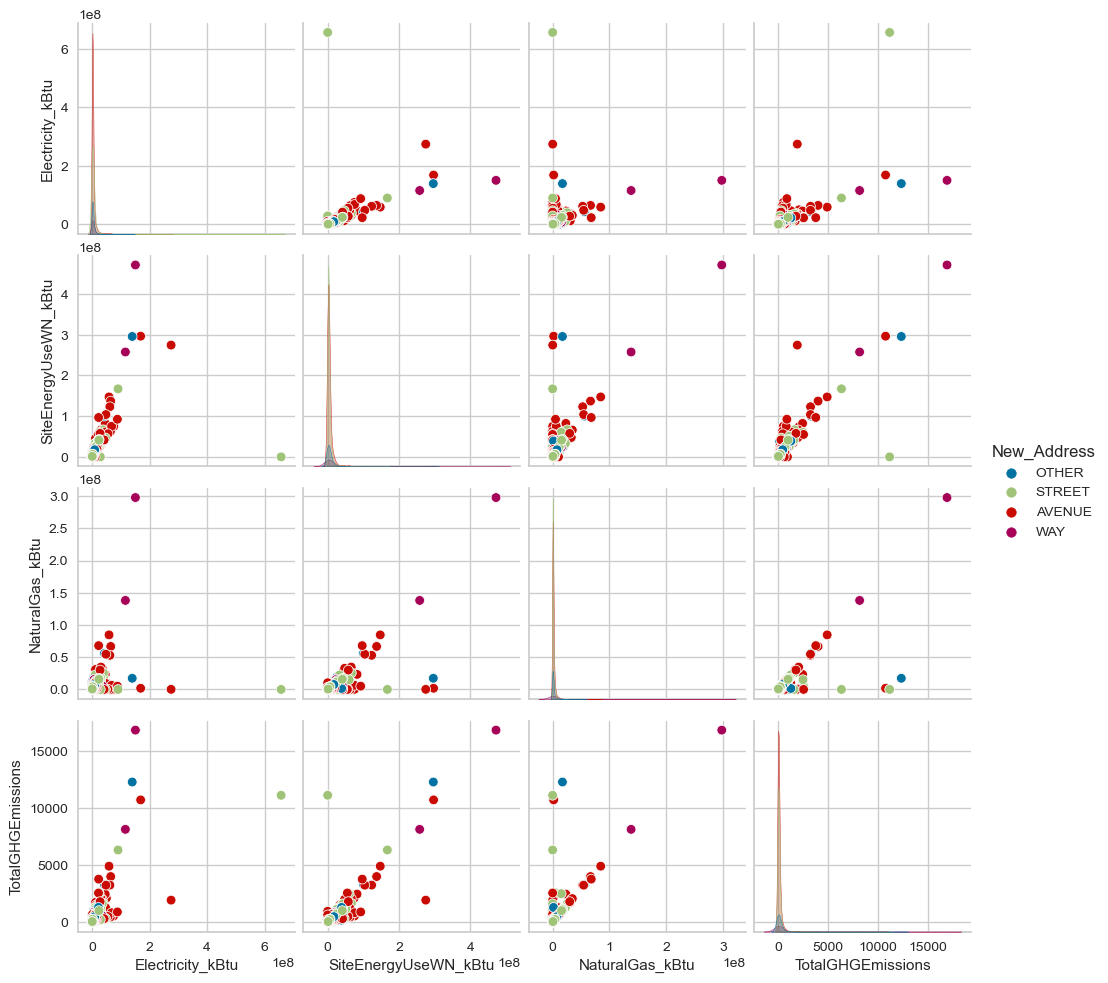

In [38]:
# Vérifier la consommation d'énergie et l'emission de gaz /contenu adresse
plt.figure(figsize=[15, 10])

sns.pairplot(data[['Electricity_kBtu','SiteEnergyUseWN_kBtu','NaturalGas_kBtu','TotalGHGEmissions','New_Address']], kind='scatter', hue='New_Address')

plt.show()

D'après cette figure, la consommation d'énergie et l'emission de gaz dépondent du contenu de l'adrese. On garde la nouvelle variable 'New_Address' et on supprime l'ancienne variable 'Address'

In [39]:
colonnes_a_supprimer.append('Address')


**Variables énergitiques**

ENERGYSTARScore : An EPA calculated 1-100 rating that assesses a property’s overall energy performance, based on national data to control for differences among climate, building uses, and operations. A score of 50 represents the national median.

SiteEUI(kBtu/sf):	Site Energy Use Intensity (EUI) is a property's Site Energy Use divided by its gross floor area. Site Energy Use is the annual amount of all the energy consumed by the property on-site, as reported on utility bills. Site EUI is measured in thousands of British thermal units (kBtu) per square foot.

SiteEUIWN(kBtu/sf) :	Weather Normalized (WN) Site Energy Use Intensity (EUI) is a property's WN Site Energy divided by its gross floor area (in square feet). WN Site Energy is the Site Energy Use the property would have consumed during 30-year average weather conditions. WN Site EUI is measured in measured in thousands of British thermal units (kBtu) per square foot.

SourceEUI(kBtu/sf) :	Source Energy Use Intensity (EUI) is a property's Source Energy Use divided by its gross floor area. Source Energy Use is the annual energy used to operate the property, including losses from generation, transmission, & distribution. Source EUI is measured in thousands of British thermal units (kBtu) per square foot.

SourceEUIWN(kBtu/sf) : Weather Normalized (WN) Source Energy Use Intensity (EUI) is a property's WN Source Energy divided by its gross floor area. WN Source Energy is the Source Energy Use the property would have consumed during 30-year average weather conditions. WN Source EUI is measured in measured in thousands of British thermal units (kBtu) per square foot.

SiteEnergyUse(kBtu) :	The annual amount of energy consumed by the property from all sources of energy.

SiteEnergyUseWN(kBtu) :	The annual amount of energy consumed by the property from all sources of energy, adjusted to what the property would have consumed during 30-year average weather conditions.

SteamUse(kBtu) :	The annual amount of district steam consumed by the property on-site, measured in thousands of British thermal units (kBtu).

Electricity(kWh) :	The annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in kWh.

Electricity(kBtu) :	The annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in thousands of British thermal units (kBtu).

NaturalGas(therms) :	The annual amount of utility-supplied natural gas consumed by the property, measured in therms.

NaturalGas(kBtu) :	The annual amount of utility-supplied natural gas consumed by the property, measured in thousands of British thermal units (kBtu).

*Unités énergitique*

kWh : kilowattheure

Therm : unité anglo-saxonne d'énergie égale à 100 000 British thermal unit (BTU)

kBtu : British thermal unit (=0,293071 KWh)

Je vais garder l'unité kBtu

In [40]:
for col in ['Electricity_kWh', 'NaturalGas_therms','Electricity_kBtu','NaturalGas_kBtu']:
  colonnes_a_supprimer.append(col)

*Suffixe WN* 

représente la consommation d'énergie que la propriété aurait consommée dans des conditions météorologiques moyennes sur 30 ans. 
On verra dans la partie features importance si on les gardes ou on les supprimes

*Suffixe _sf* 

représente la consommation d'énergie divisée par la surface. 
Ce sont des variables calculées à partir d'autres donc  à supprimer

In [41]:
for col in ['SiteEUIWN_kBtu_sf','SourceEUIWN_kBtu_sf','SourceEUI_kBtu_sf','PropertyGFABuilding_s',  'SiteEnergyUseWN_kBtu']:
  colonnes_a_supprimer.append(col)


## supprimer les bâtiments habitables

In [42]:
data.shape

(3376, 48)

In [43]:
val_colonne('BuildingType')

nbre_valeurs :  8
Liste_valeurs :  ['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)', 'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)', 'Multifamily HR (10+)', 'Nonresidential WA']


In [44]:
data.drop(data.loc[data['BuildingType']=='Multifamily MR (5-9)'].index, inplace=True)
data.drop(data.loc[data['BuildingType']=='Multifamily LR (1-4)'].index, inplace=True)
data.drop(data.loc[data['BuildingType']=='Multifamily HR (10+)'].index, inplace=True)

In [45]:
data.shape

(1668, 48)

## Supprimer les colonnes sélectionnées

In [46]:
data = data.drop(colonnes_a_supprimer, 1)

In [47]:
data.shape

(1668, 25)

# 3.  Imputation des valeurs manquantes

In [48]:
def informations_valeurs_manqantes(df):
  print('Nombre de valeurs manquantes par colonne')
  msno.bar(df)
  print(100*'*')
  print('Matrice de chaleur des valeurs manquantes')
  msno.heatmap(df)
  print(100*'*')
  print('Dendogramme des valeurs manquantes')
  msno.dendrogram(df)
  print(100*'*')

Nombre de valeurs manquantes par colonne
****************************************************************************************************
Matrice de chaleur des valeurs manquantes
****************************************************************************************************
Dendogramme des valeurs manquantes
****************************************************************************************************


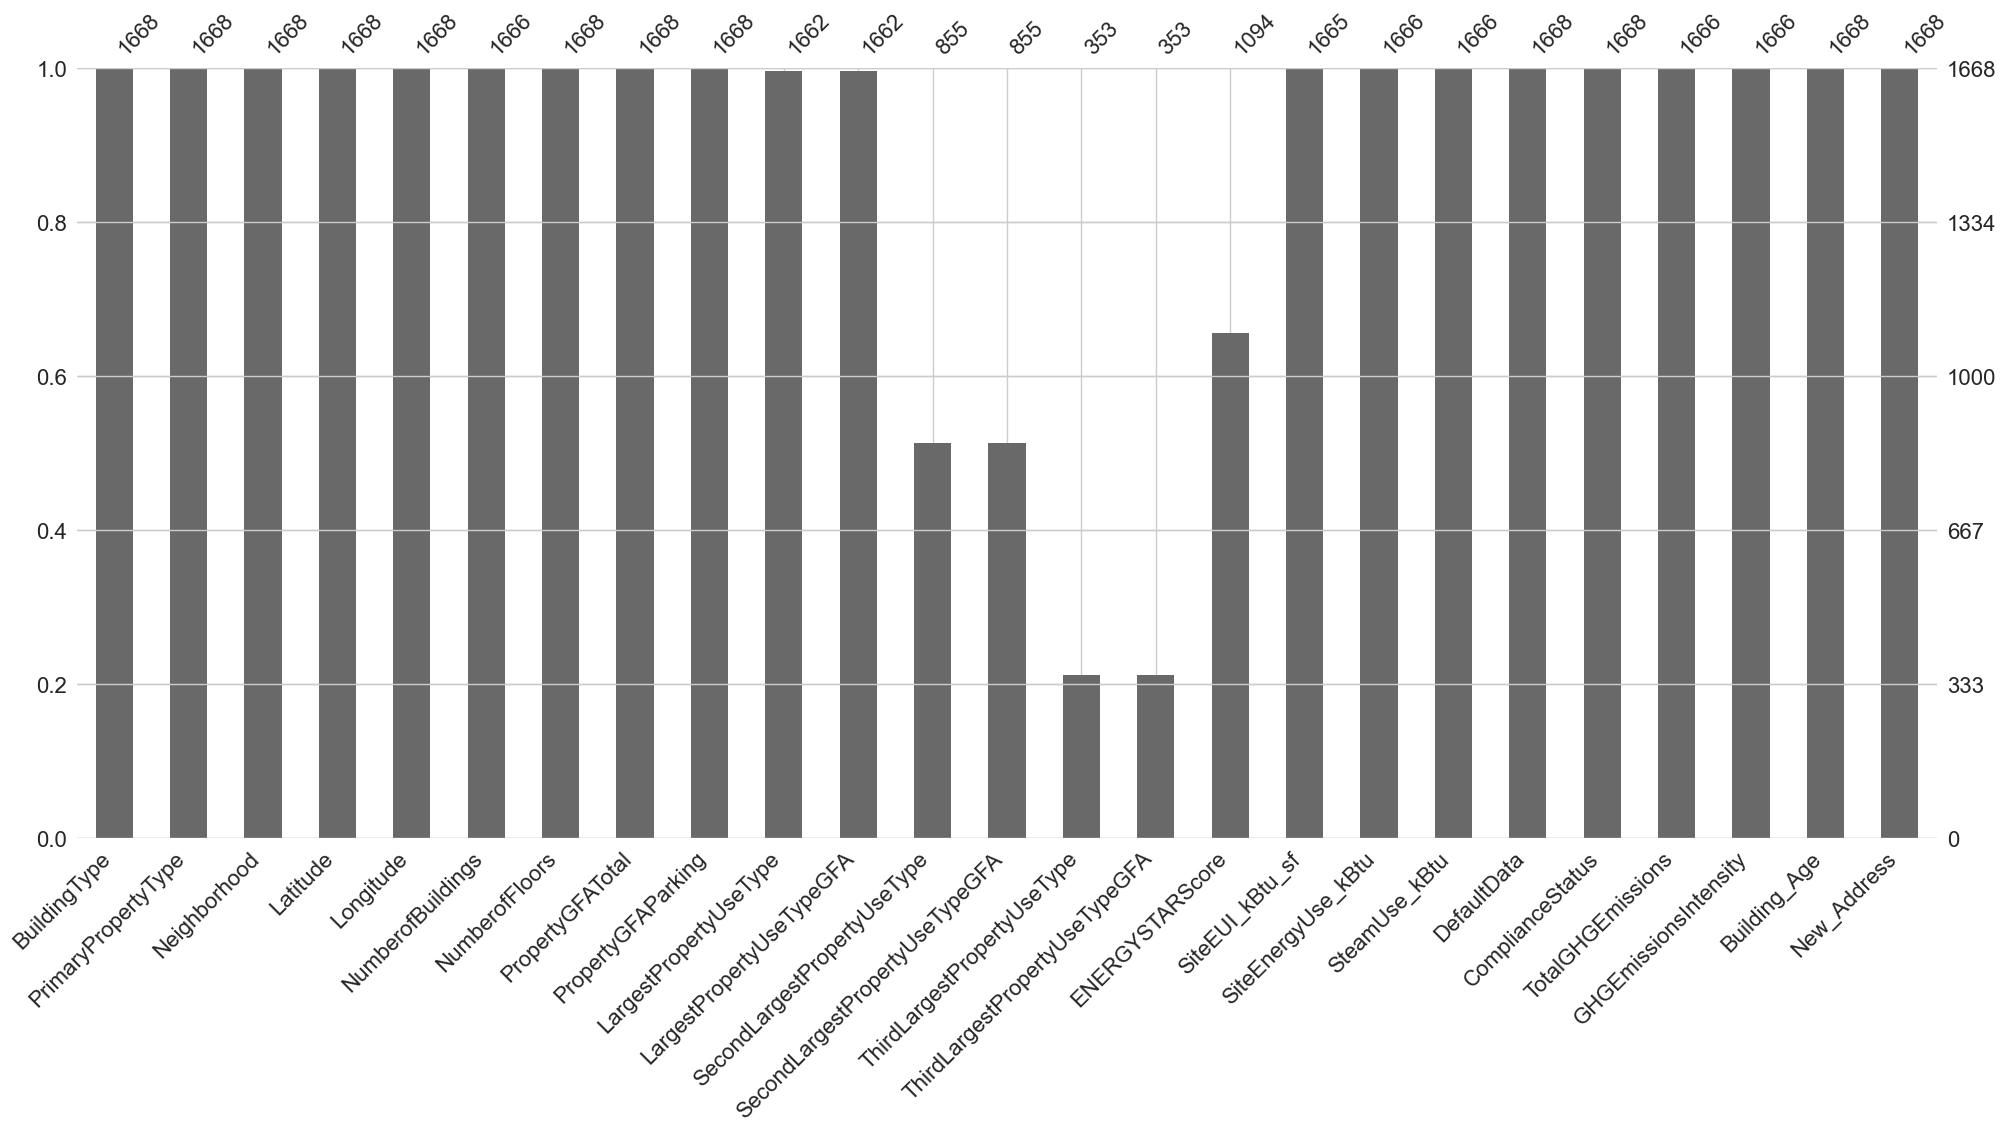

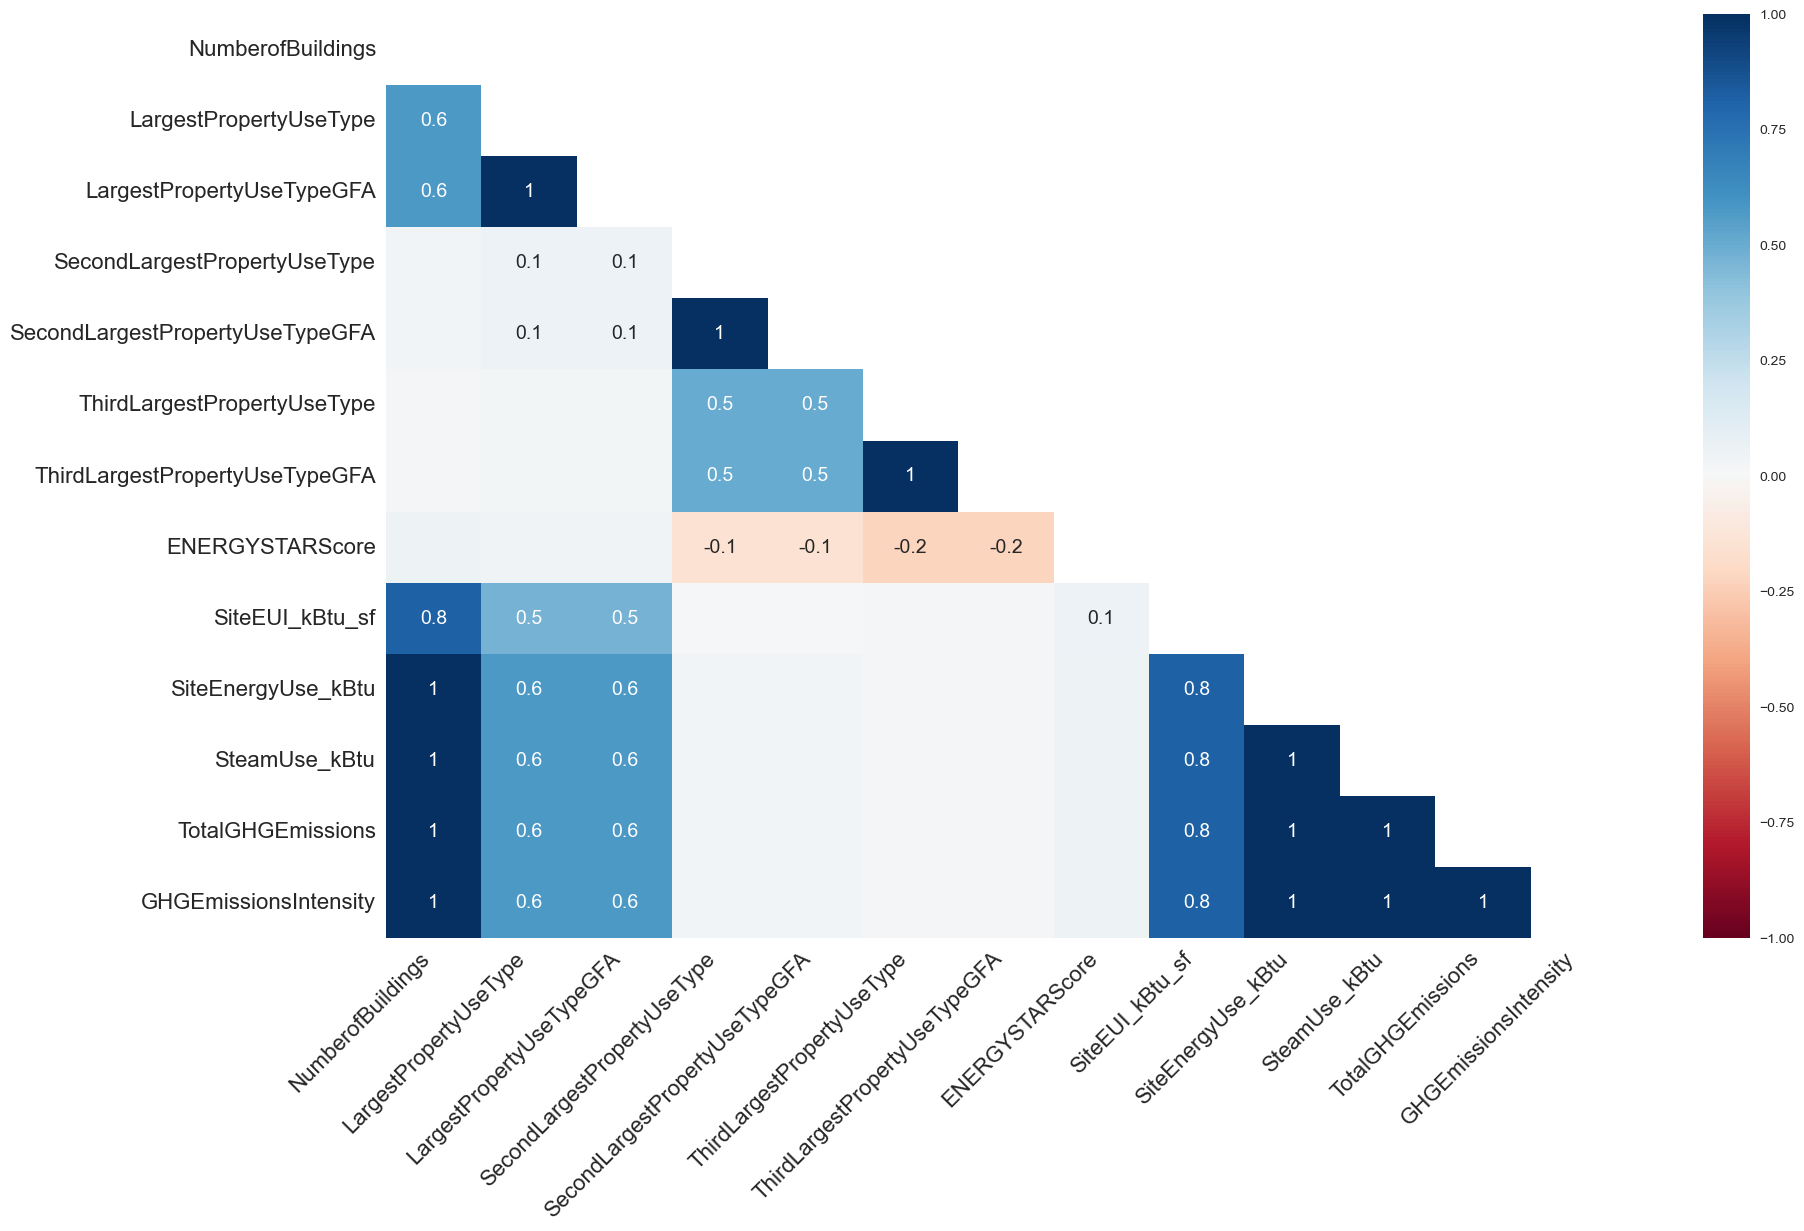

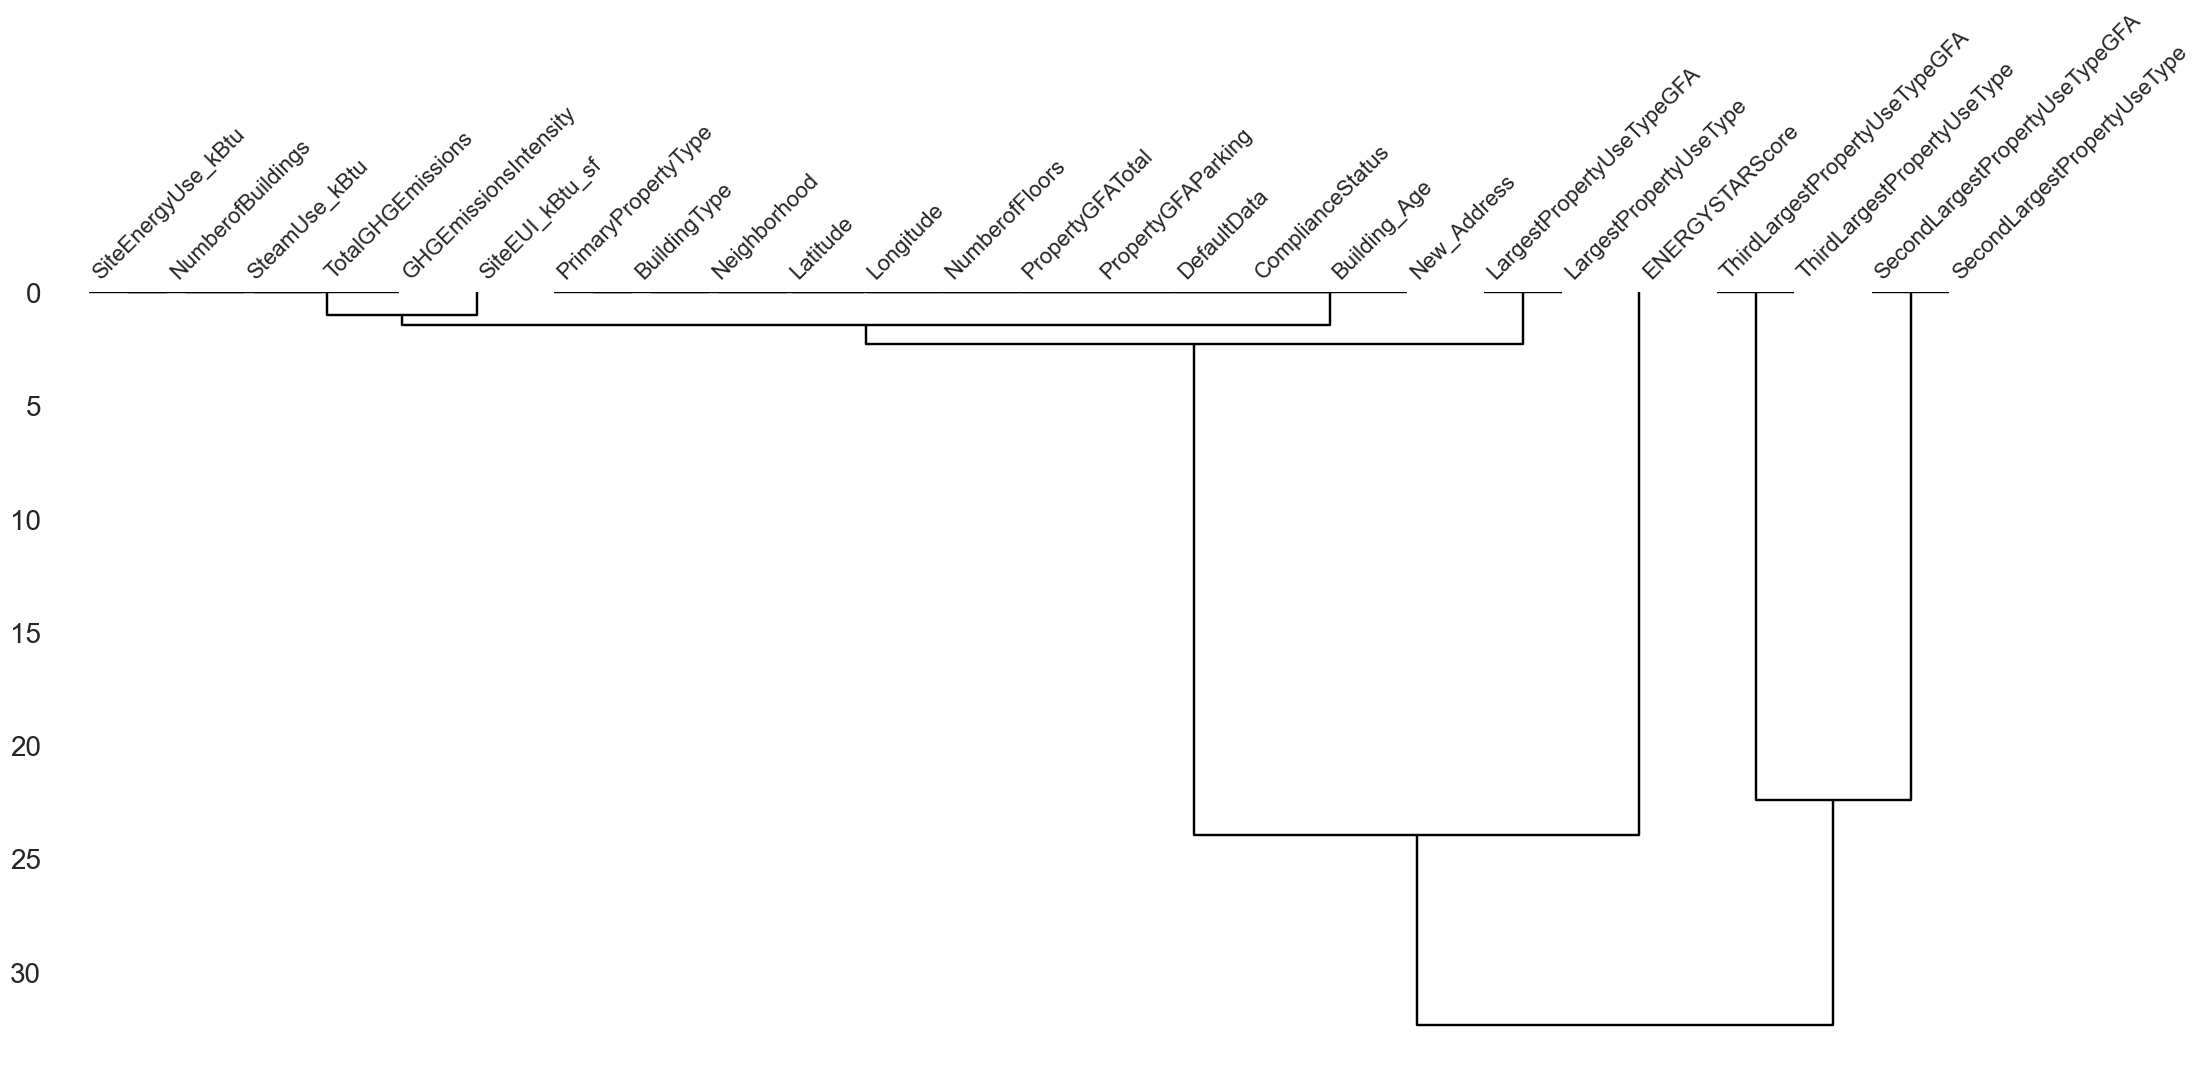

In [49]:
informations_valeurs_manqantes(data)

**Variable ENERGYSTARScore**

On doit étudier la pertinence de cette variable  donc une imputation biaiserai notre étude. Pour le moment, je vais laisser cette variable telle quelle est.

**Variables cibles**

Supprimer les valeurs nulles des deux variables cibles SiteEnergyUse_kBtu  et
TotalGHGEmissions.

In [50]:
data = data[~(data['SiteEnergyUse_kBtu'].isna() | data['TotalGHGEmissions'].isna())]


**Variables categorielles**

In [51]:
# Le nombre de valeurs de chaque variable objet
data.select_dtypes(['object']).nunique()

BuildingType                     5
PrimaryPropertyType              9
Neighborhood                    14
LargestPropertyUseType          10
SecondLargestPropertyUseType    10
ThirdLargestPropertyUseType     10
ComplianceStatus                 4
New_Address                      4
dtype: int64

In [52]:
data.select_dtypes(['object']).isnull().mean()

BuildingType                    0.000000
PrimaryPropertyType             0.000000
Neighborhood                    0.000000
LargestPropertyUseType          0.002401
SecondLargestPropertyUseType    0.486795
ThirdLargestPropertyUseType     0.788115
ComplianceStatus                0.000000
New_Address                     0.000000
dtype: float64

Si PrimaryPropertyType   manquantes, on impute par la valeur "unknown"          

Si SecondLargestPropertyUseType manquantes, on impute par la variable  PrimaryPropertyType

Si ThirdLargestPropertyUseType, on impute par la variable SecondLargestPropertyUseType

Si LargestPropertyUseType   manquantes, on impute par la variable  PrimaryPropertyType

In [53]:
data['PrimaryPropertyType'] = data['PrimaryPropertyType'].fillna("unknown")
data['SecondLargestPropertyUseType'] = data['SecondLargestPropertyUseType'].fillna(data['PrimaryPropertyType'])
data['ThirdLargestPropertyUseType'] = data['ThirdLargestPropertyUseType'].fillna(data['SecondLargestPropertyUseType'])
data['LargestPropertyUseType'] = data['LargestPropertyUseType'].fillna(data['PrimaryPropertyType'])

In [54]:
# verifier s'il y a encore des données manquantes dans les variables categorielles
data.select_dtypes(['object']).isnull().mean()

BuildingType                    0.0
PrimaryPropertyType             0.0
Neighborhood                    0.0
LargestPropertyUseType          0.0
SecondLargestPropertyUseType    0.0
ThirdLargestPropertyUseType     0.0
ComplianceStatus                0.0
New_Address                     0.0
dtype: float64

**Variables continues**

In [55]:
def imputation_mediane(df,col_imputation,col_groupby):
  df[col_imputation].fillna(df.groupby(col_groupby)[col_imputation].transform('median'), inplace = True)
  # Il reste quelques valeurs nulles dont le groupement n'a pa de mediane. On les remplace par 0
  df[col_imputation].fillna(0, inplace = True)

In [56]:
def distribution_avant_apres(df_avant, df_apres, colonne_cible):
  colonne_cible_apres_imputation = colonne_cible+'_apres_imputation'
  sns.kdeplot(colonne_cible, data = df_avant, label=colonne_cible)
  sns.kdeplot(colonne_cible, data = df_apres, label=colonne_cible_apres_imputation)
  plt.title(f'comparaison des distributions prediction colonne {colonne_cible}')
  plt.legend()
  plt.show()

In [57]:
 
colonnes_median = {'SecondLargestPropertyUseTypeGFA':'SecondLargestPropertyUseType',
                   'ThirdLargestPropertyUseTypeGFA':'ThirdLargestPropertyUseType',
                   'LargestPropertyUseTypeGFA':'LargestPropertyUseType'}
# garder une copie des données avant imputation
data_median = data[list(colonnes_median.keys())].copy()
# imputation par la mediane des categories (groupby sur les colonne 'main_category_fr')
for col_imputation,col_groupby in colonnes_median.items():
  imputation_mediane(data,col_imputation,col_groupby)
  
# 2eme copie après imputation pour faire la comparaison des distributins
data_median_imputed = data[list(colonnes_median.keys())].copy()

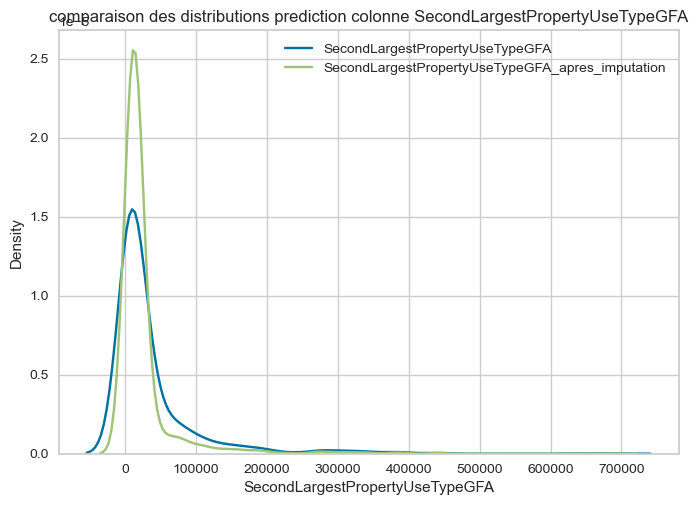

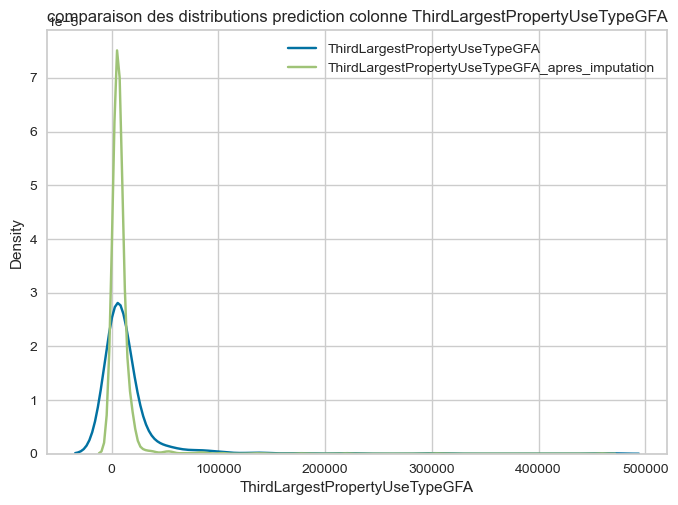

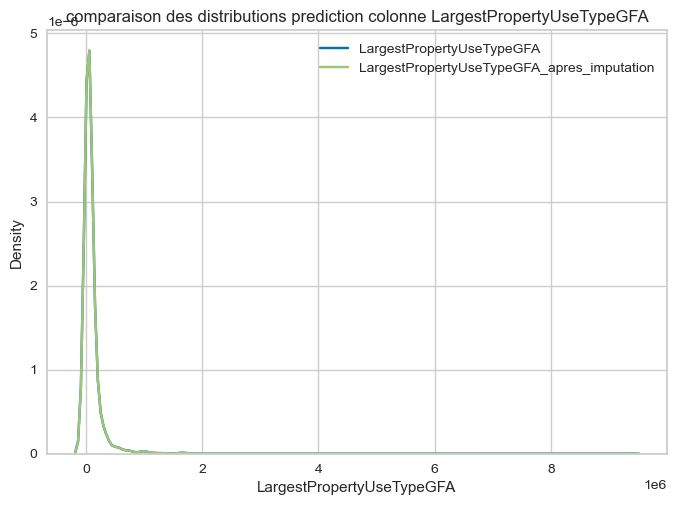

In [58]:
for colonne_cible in list(colonnes_median.keys()):
  distribution_avant_apres(data_median, data_median_imputed, colonne_cible)

In [59]:
for colonne in list(colonnes_median.keys()):
    data[colonne] = data_median_imputed[colonne]


In [60]:
# verifier s'il y a encore des données manquantes autre que la variable ENERGYSTARScore  
data.isnull().mean()

BuildingType                       0.000000
PrimaryPropertyType                0.000000
Neighborhood                       0.000000
Latitude                           0.000000
Longitude                          0.000000
NumberofBuildings                  0.000000
NumberofFloors                     0.000000
PropertyGFATotal                   0.000000
PropertyGFAParking                 0.000000
LargestPropertyUseType             0.000000
LargestPropertyUseTypeGFA          0.000000
SecondLargestPropertyUseType       0.000000
SecondLargestPropertyUseTypeGFA    0.000000
ThirdLargestPropertyUseType        0.000000
ThirdLargestPropertyUseTypeGFA     0.000000
ENERGYSTARScore                    0.343337
SiteEUI_kBtu_sf                    0.000600
SiteEnergyUse_kBtu                 0.000000
SteamUse_kBtu                      0.000000
DefaultData                        0.000000
ComplianceStatus                   0.000000
TotalGHGEmissions                  0.000000
GHGEmissionsIntensity           

In [61]:
data.shape

(1666, 25)

# 4.  Analyse valeur aberrante

**Boite à moustaches**

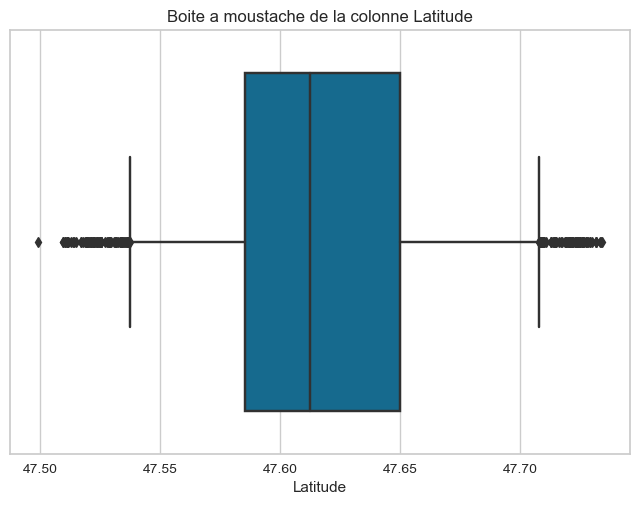

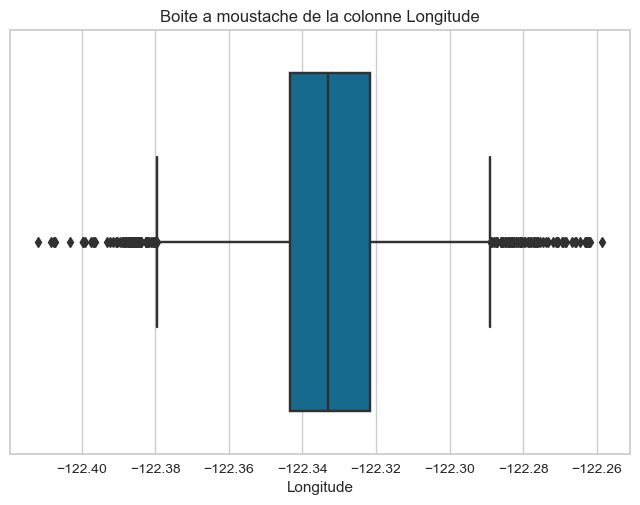

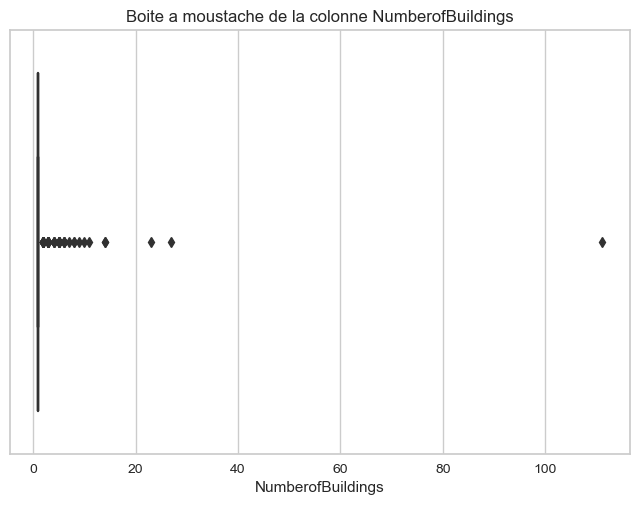

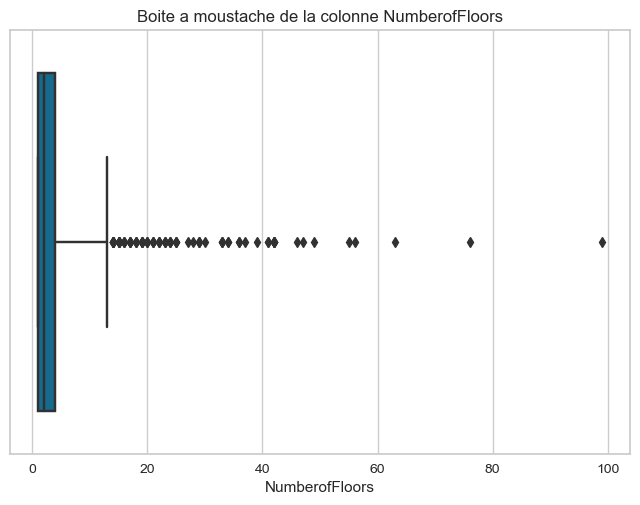

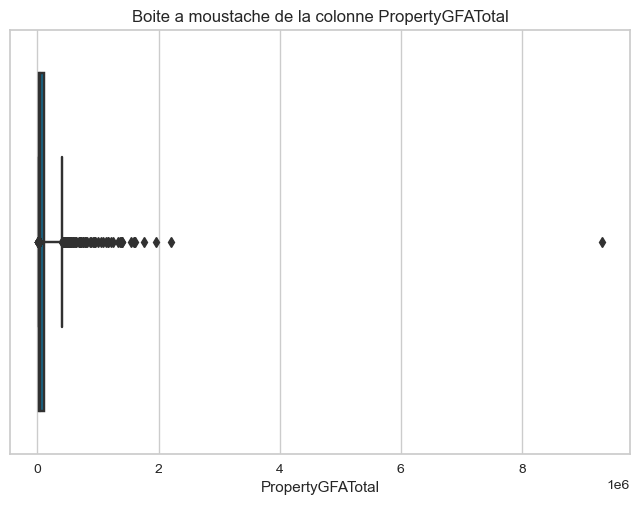

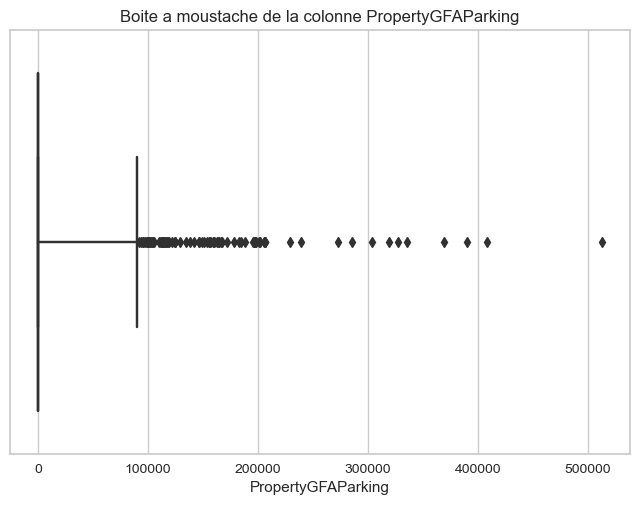

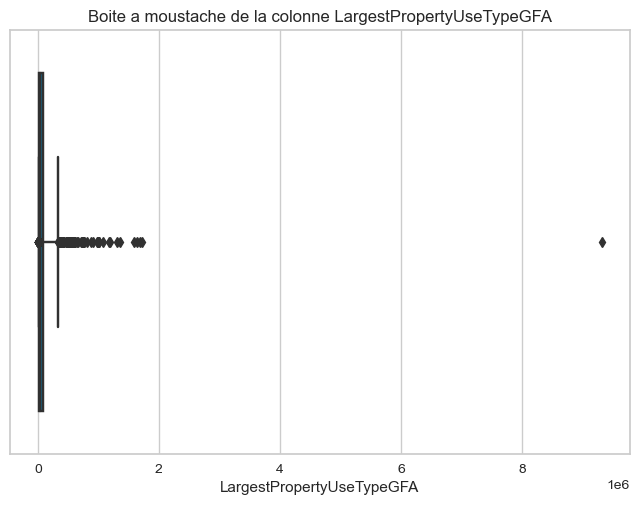

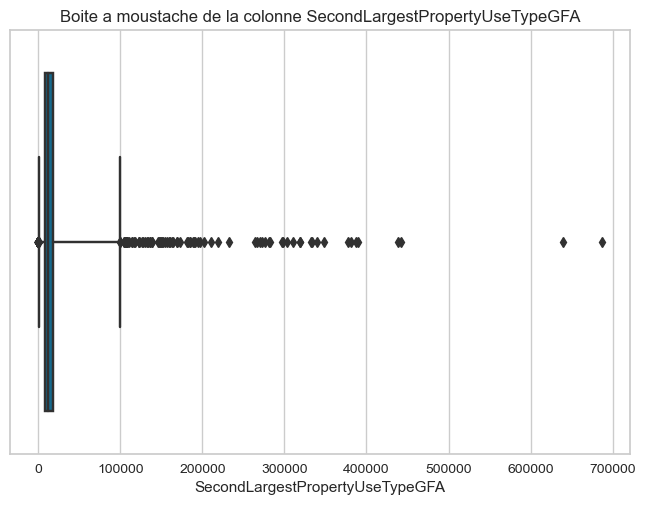

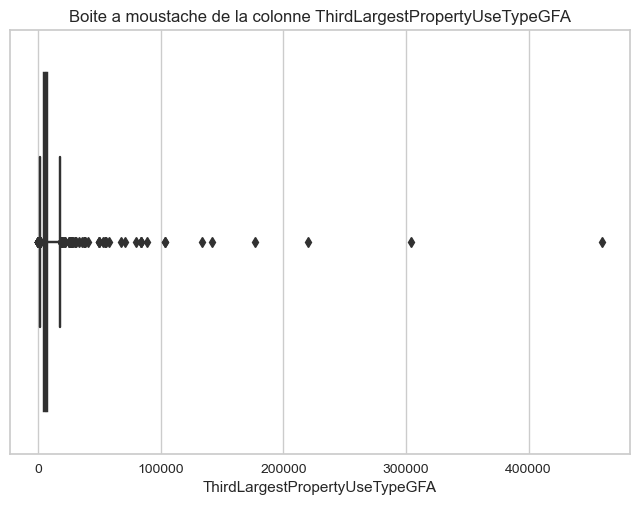

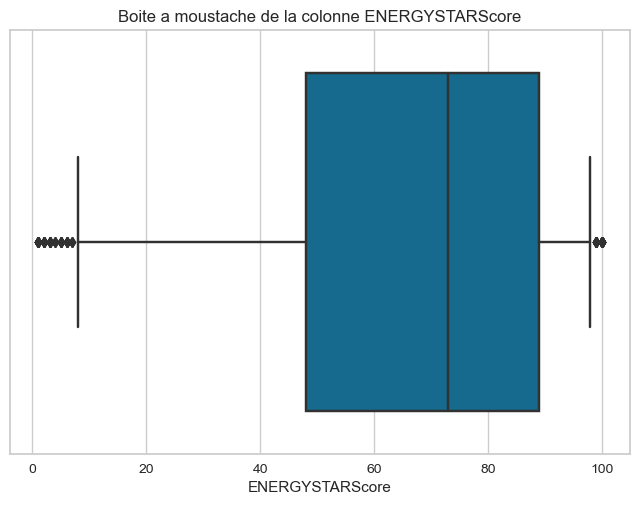

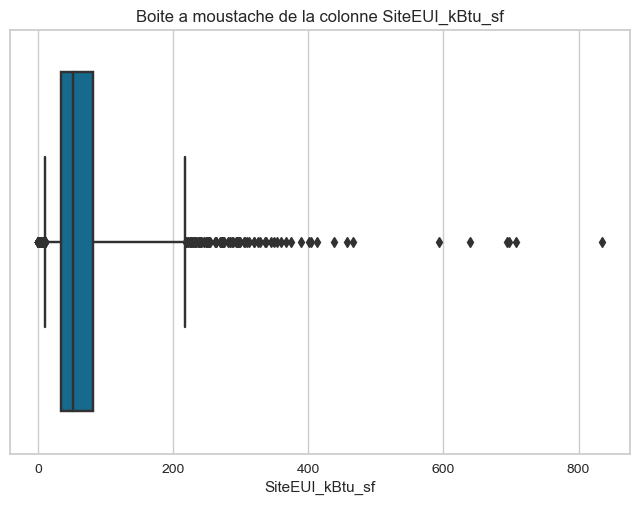

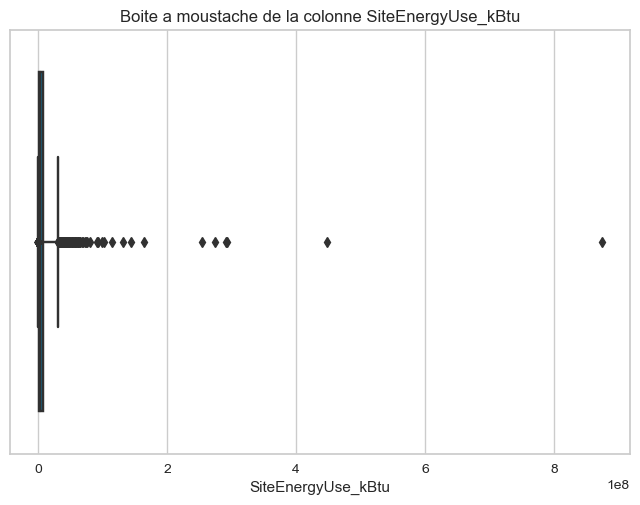

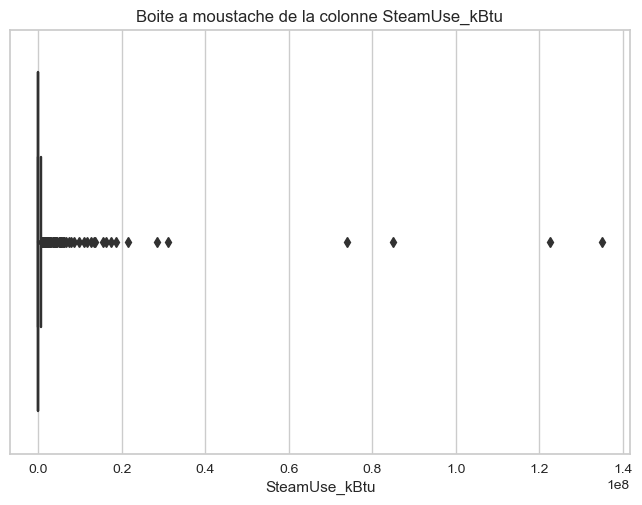

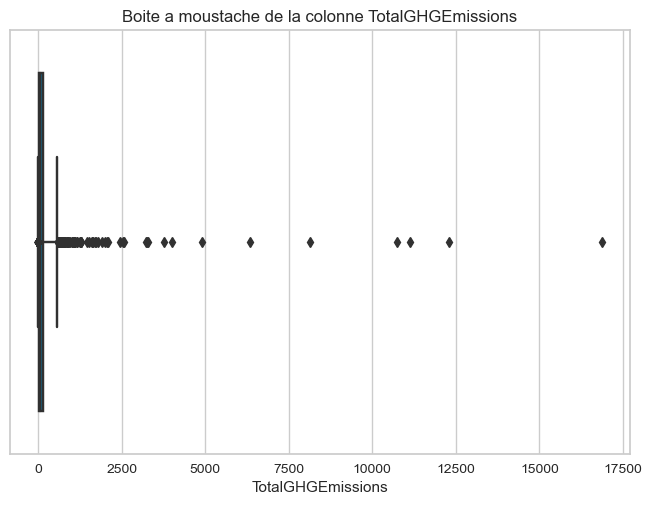

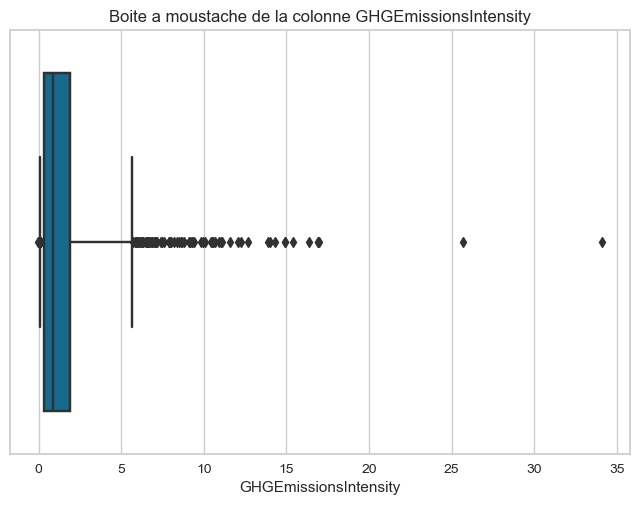

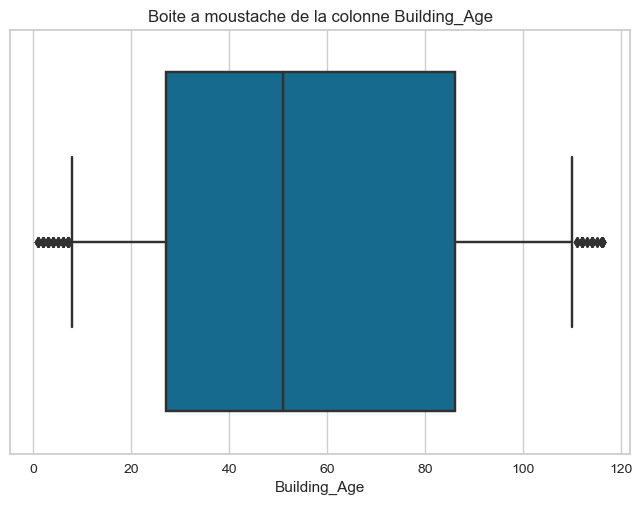

In [62]:
for colonne in data.select_dtypes(include=[np.number]).columns.tolist():
    sns.boxplot(x=colonne, data = data,whis=[5, 95])
    plt.title(('Boite a moustache de la colonne ' + colonne))
    #fichier ='moustache_'+colonne+'.png'
    #plt.savefig(fichier)
    plt.show()

D'après ces boites à moustaches, nous observons qu'il ya des valeurs aberrantes pour la majorité des colonnes.
Je vais traiter ces valeurs aberranes par la méthode des quartiles (0.05 comme quartile inf et 0.95 comme quartile sup pour ne pas perdre beaucoups d'observations). Le nombre d'observations est déjà petit (environ 1600).


In [63]:
colonnes_aberrantes = ['PropertyGFATotal',
                      'PropertyGFAParking',
                      'LargestPropertyUseTypeGFA',
                      'SecondLargestPropertyUseTypeGFA',
                      'ThirdLargestPropertyUseTypeGFA',
                      'SiteEUI_kBtu_sf',
                      'SteamUse_kBtu',
                      'TotalGHGEmissions',
                      'GHGEmissionsIntensity',]

In [64]:
def traitement_valeurs_aberrantes(data,colonne):
    Q1 = data[colonne].quantile(0.05)
    Q3 = data[colonne].quantile(0.95)
    borneInf = Q1 - 1.5*(Q3 - Q1)
    borneSup = Q3 + 1.5*(Q3 - Q1)    
    data.drop(data.loc[data[colonne] > borneSup].index, inplace = True)
    data.drop(data.loc[data[colonne] < borneInf].index, inplace = True)

In [65]:

for colonne in colonnes_aberrantes:
  traitement_valeurs_aberrantes(data,colonne)


In [66]:
# Supprimer les valeurs négatives

data = data.loc[data['SiteEnergyUse_kBtu'] > 0]
data = data.loc[data['TotalGHGEmissions'] > 0]

In [67]:
data.shape

(1506, 25)

**ré-indexer le dataframe après tous les traitements effectués**

In [68]:
data=data.reset_index(drop = True)


# 5.  Analyse univariée

In [69]:
def analyse_univariee(data,colonne,label):
    print(f'moyenne : {round(data[colonne].mean(),2)}')
    print(f'mediane : {round(data[colonne].median(),2)}')
    print(f'mode : {round(data[colonne].mode(),2)}')
    print(f'variance : {round(data[colonne].var(),2)}')
    print(f'skewness : {round(data[colonne].skew(),2)}')
    print(f'kurtosis : {round(data[colonne].kurtosis(),2)}')
    print(f'ecart type : {round(data[colonne].std(),2)}')
    print(f'min : {round(data[colonne].min(),2)}')
    print(f'25% : {round(data[colonne].quantile(0.25),2)}')
    print(f'50% : {round(data[colonne].quantile(0.5),2)}')
    print(f'75% : {round(data[colonne].quantile(0.75),2)}')
    print(f'max : {round(data[colonne].max(),2)}')
    print(colored('Interprétation', 'red', attrs=['bold']))
    if np.floor(data[colonne].skew())==0:
        print('la distribution de la colonne '+colonne +' est symétrique')
    elif round(data[colonne].skew(),2)>0:
        print('la distribution de la colonne '+colonne + ' est étalée à droite')
    else:
        print('la distribution de la colonne '+colonne +' est étalée à gauche')
    
    if np.floor(data[colonne].kurtosis())==0:
        print('la distribution de la colonne '+colonne +' a le même aplatissement que la distribution normale')
    elif round(data[colonne].kurtosis(),2)>0:
        print('la distribution de la colonne '+colonne + ' est moins aplatie que la distribution normale')
    else:
        print('la distribution de la colonne '+colonne +' est plus aplatie que la distribution normale')
                   
    plt.figure(figsize=(15, 5))
    plt.subplot( 1,2 ,1)
    sns.boxplot(data[colonne], width=0.5, color='red')
    plt.title('Boite a moustache de la colonne '+label,fontsize=15)
    plt.subplot(1,2,2 )
    sns.histplot(data[colonne], kde=True, color='blue')
    plt.title('histogramme de la colonne  '+label,fontsize=15)        
    plt.show()       
    plt.tight_layout()
                  

In [70]:
colonnes_numeriques = data.select_dtypes(include=[np.number]).columns.tolist()


******************************************************************************************************************************************************
Analyse de la colonne Latitude
moyenne : 47.62
mediane : 47.61
mode : 0    47.66
Name: Latitude, dtype: float64
variance : 0.0
skewness : 0.21
kurtosis : -0.39
ecart type : 0.05
min : 47.5
25% : 47.58
50% : 47.61
75% : 47.65
max : 47.73
Interprétation
la distribution de la colonne Latitude est symétrique
la distribution de la colonne Latitude est plus aplatie que la distribution normale


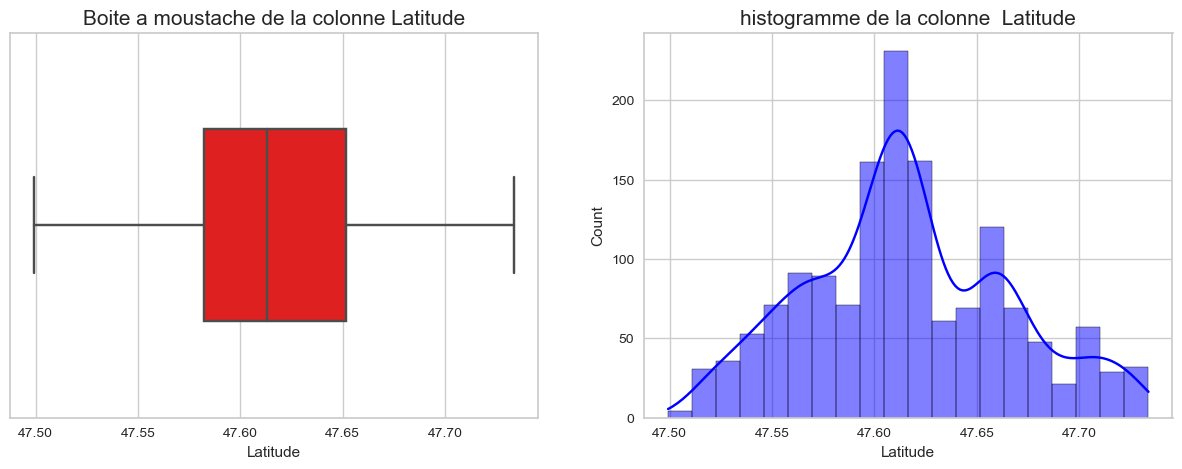

******************************************************************************************************************************************************
Analyse de la colonne Longitude
moyenne : -122.33
mediane : -122.33
mode : 0   -122.3
Name: Longitude, dtype: float64
variance : 0.0
skewness : -0.07
kurtosis : 0.6
ecart type : 0.03
min : -122.41
25% : -122.34
50% : -122.33
75% : -122.32
max : -122.26
Interprétation
la distribution de la colonne Longitude est étalée à gauche
la distribution de la colonne Longitude a le même aplatissement que la distribution normale


<Figure size 800x550 with 0 Axes>

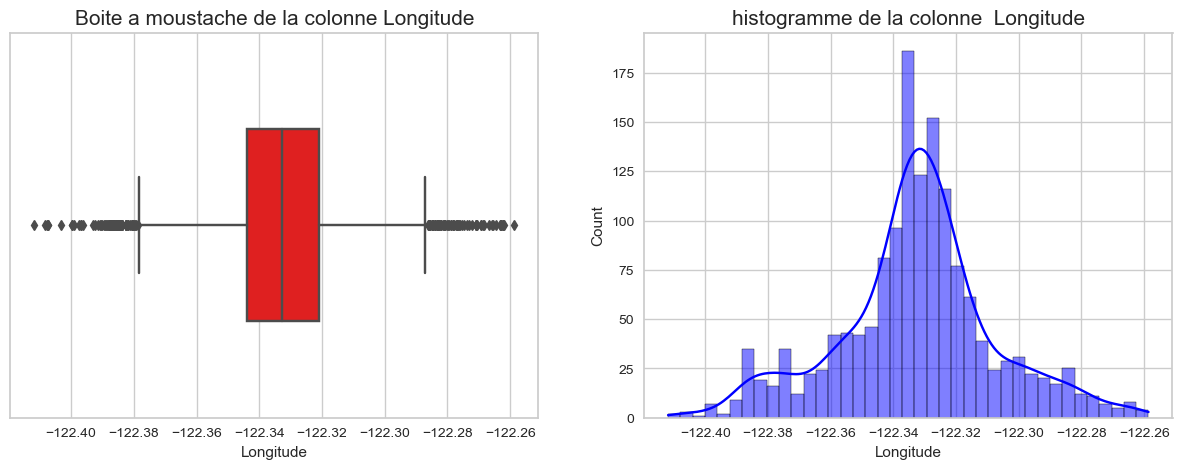

******************************************************************************************************************************************************
Analyse de la colonne NumberofBuildings
moyenne : 1.11
mediane : 1.0
mode : 0    1.0
Name: NumberofBuildings, dtype: float64
variance : 1.19
skewness : 16.76
kurtosis : 338.24
ecart type : 1.09
min : 1.0
25% : 1.0
50% : 1.0
75% : 1.0
max : 27.0
Interprétation
la distribution de la colonne NumberofBuildings est étalée à droite
la distribution de la colonne NumberofBuildings est moins aplatie que la distribution normale


<Figure size 800x550 with 0 Axes>

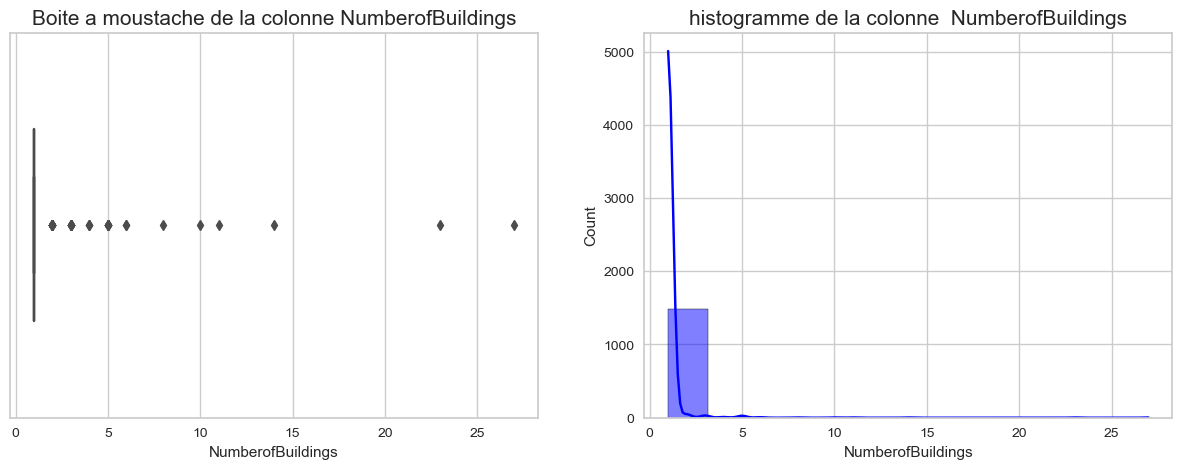

******************************************************************************************************************************************************
Analyse de la colonne NumberofFloors
moyenne : 3.35
mediane : 2.0
mode : 0    1
Name: NumberofFloors, dtype: int64
variance : 21.35
skewness : 8.84
kurtosis : 137.71
ecart type : 4.62
min : 1
25% : 1.0
50% : 2.0
75% : 4.0
max : 99
Interprétation
la distribution de la colonne NumberofFloors est étalée à droite
la distribution de la colonne NumberofFloors est moins aplatie que la distribution normale


<Figure size 800x550 with 0 Axes>

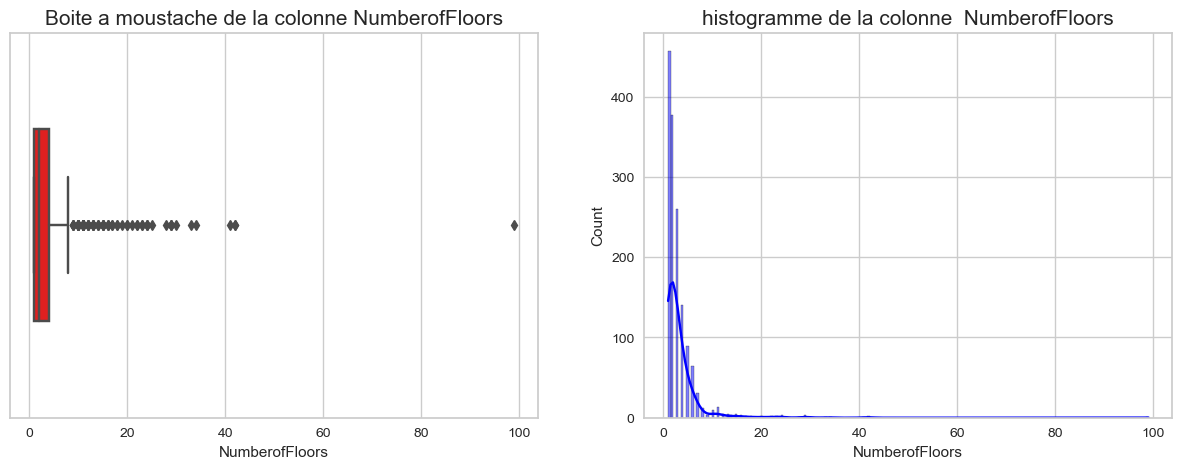

******************************************************************************************************************************************************
Analyse de la colonne PropertyGFATotal
moyenne : 81187.81
mediane : 45267.5
mode : 0    25920
1    28800
Name: PropertyGFATotal, dtype: int64
variance : 9499397610.45
skewness : 3.25
kurtosis : 13.08
ecart type : 97464.85
min : 11285
25% : 28441.75
50% : 45267.5
75% : 89175.75
max : 791396
Interprétation
la distribution de la colonne PropertyGFATotal est étalée à droite
la distribution de la colonne PropertyGFATotal est moins aplatie que la distribution normale


<Figure size 800x550 with 0 Axes>

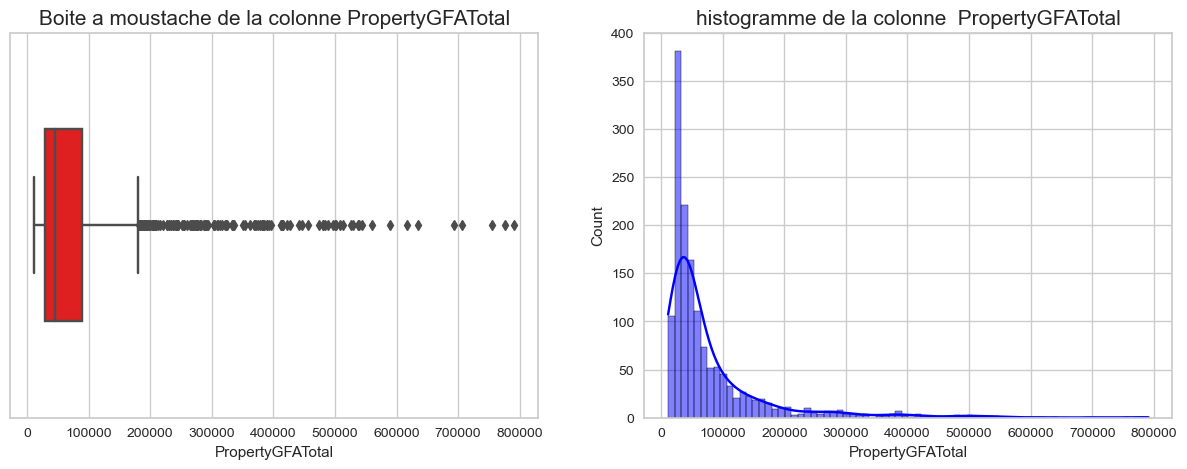

******************************************************************************************************************************************************
Analyse de la colonne PropertyGFAParking
moyenne : 9234.29
mediane : 0.0
mode : 0    0
Name: PropertyGFAParking, dtype: int64
variance : 826467799.55
skewness : 4.18
kurtosis : 19.11
ecart type : 28748.35
min : 0
25% : 0.0
50% : 0.0
75% : 0.0
max : 206597
Interprétation
la distribution de la colonne PropertyGFAParking est étalée à droite
la distribution de la colonne PropertyGFAParking est moins aplatie que la distribution normale


<Figure size 800x550 with 0 Axes>

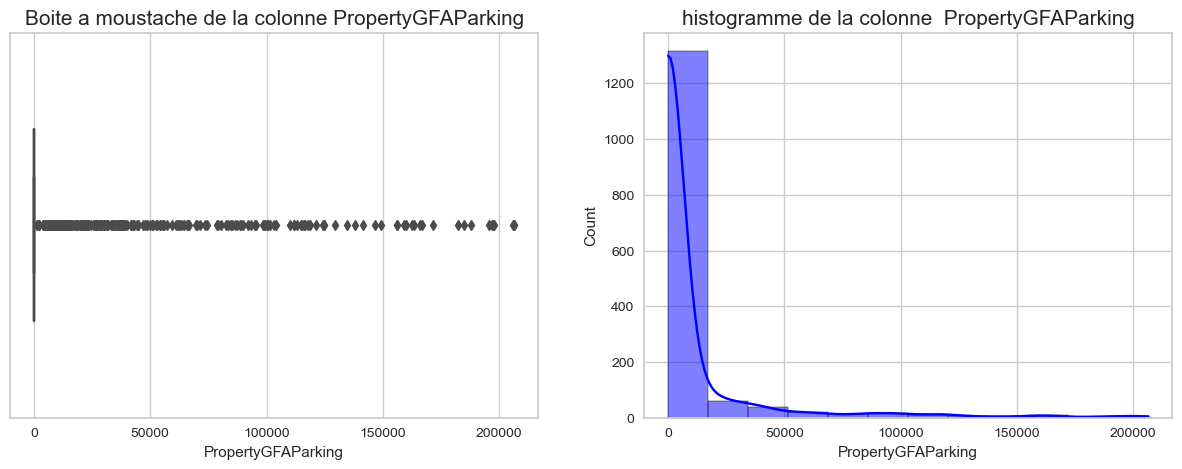

******************************************************************************************************************************************************
Analyse de la colonne LargestPropertyUseTypeGFA
moyenne : 67156.38
mediane : 40278.5
mode : 0    24000.0
1    30000.0
Name: LargestPropertyUseTypeGFA, dtype: float64
variance : 6173630070.3
skewness : 3.34
kurtosis : 14.57
ecart type : 78572.45
min : 5656.0
25% : 24292.0
50% : 40278.5
75% : 74075.75
max : 667335.0
Interprétation
la distribution de la colonne LargestPropertyUseTypeGFA est étalée à droite
la distribution de la colonne LargestPropertyUseTypeGFA est moins aplatie que la distribution normale


<Figure size 800x550 with 0 Axes>

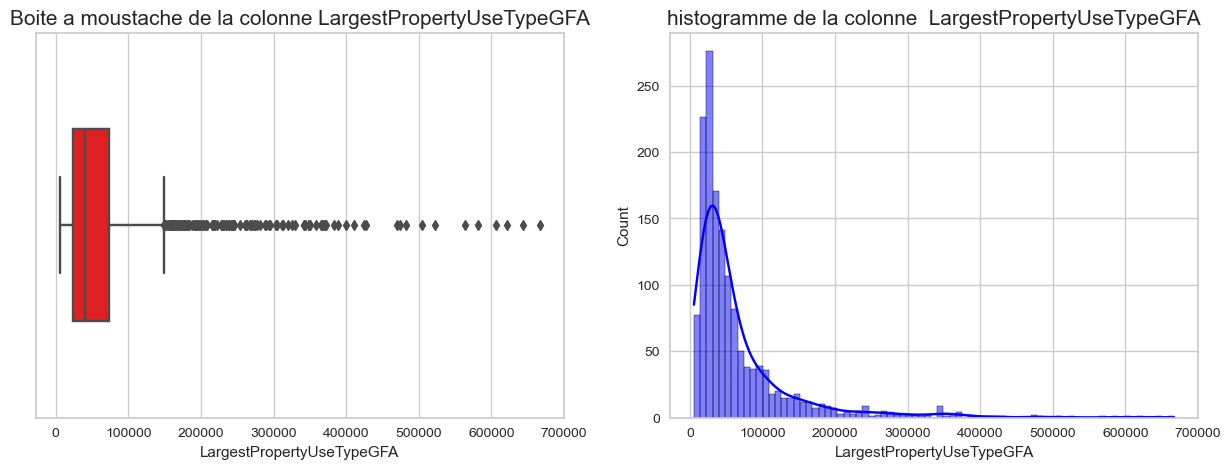

******************************************************************************************************************************************************
Analyse de la colonne SecondLargestPropertyUseTypeGFA
moyenne : 18540.91
mediane : 11372.5
mode : 0    10253.0
Name: SecondLargestPropertyUseTypeGFA, dtype: float64
variance : 582344715.46
skewness : 3.95
kurtosis : 18.68
ecart type : 24131.82
min : 0.0
25% : 8800.0
50% : 11372.5
75% : 18590.0
max : 202178.0
Interprétation
la distribution de la colonne SecondLargestPropertyUseTypeGFA est étalée à droite
la distribution de la colonne SecondLargestPropertyUseTypeGFA est moins aplatie que la distribution normale


<Figure size 800x550 with 0 Axes>

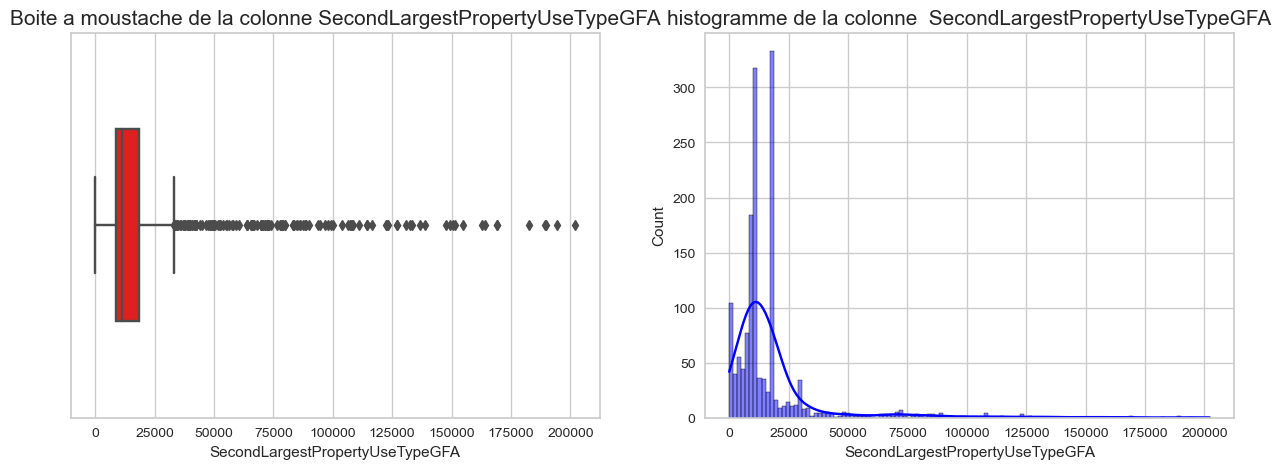

******************************************************************************************************************************************************
Analyse de la colonne ThirdLargestPropertyUseTypeGFA
moyenne : 6716.05
mediane : 6312.6
mode : 0    6344.0
Name: ThirdLargestPropertyUseTypeGFA, dtype: float64
variance : 21578845.87
skewness : 2.4
kurtosis : 9.67
ecart type : 4645.3
min : 0.0
25% : 4889.0
50% : 6312.6
75% : 6344.0
max : 41014.0
Interprétation
la distribution de la colonne ThirdLargestPropertyUseTypeGFA est étalée à droite
la distribution de la colonne ThirdLargestPropertyUseTypeGFA est moins aplatie que la distribution normale


<Figure size 800x550 with 0 Axes>

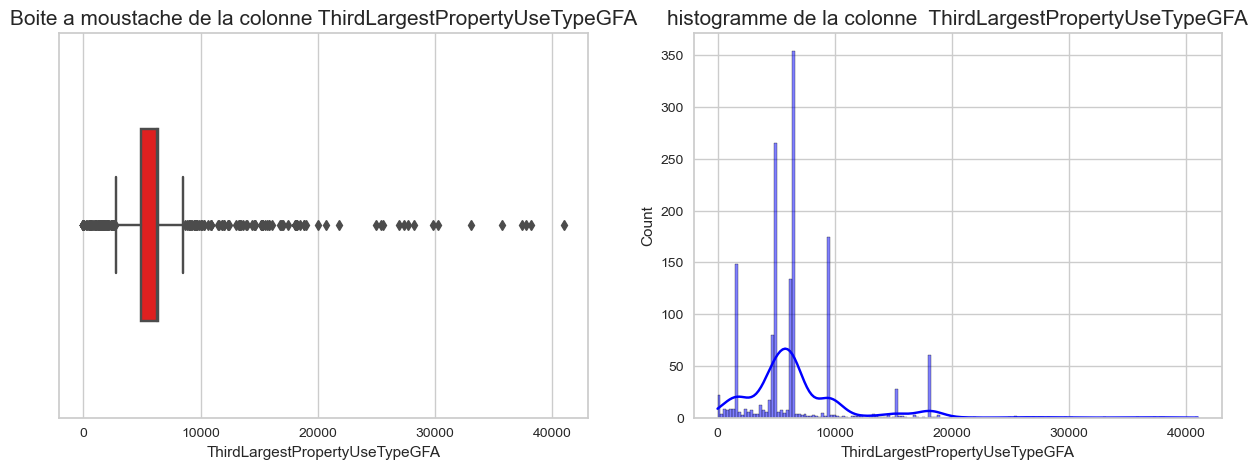

******************************************************************************************************************************************************
Analyse de la colonne ENERGYSTARScore
moyenne : 65.34
mediane : 73.0
mode : 0    100.0
Name: ENERGYSTARScore, dtype: float64
variance : 808.23
skewness : -0.78
kurtosis : -0.5
ecart type : 28.43
min : 1.0
25% : 48.0
50% : 73.0
75% : 89.0
max : 100.0
Interprétation
la distribution de la colonne ENERGYSTARScore est étalée à gauche
la distribution de la colonne ENERGYSTARScore est plus aplatie que la distribution normale


<Figure size 800x550 with 0 Axes>

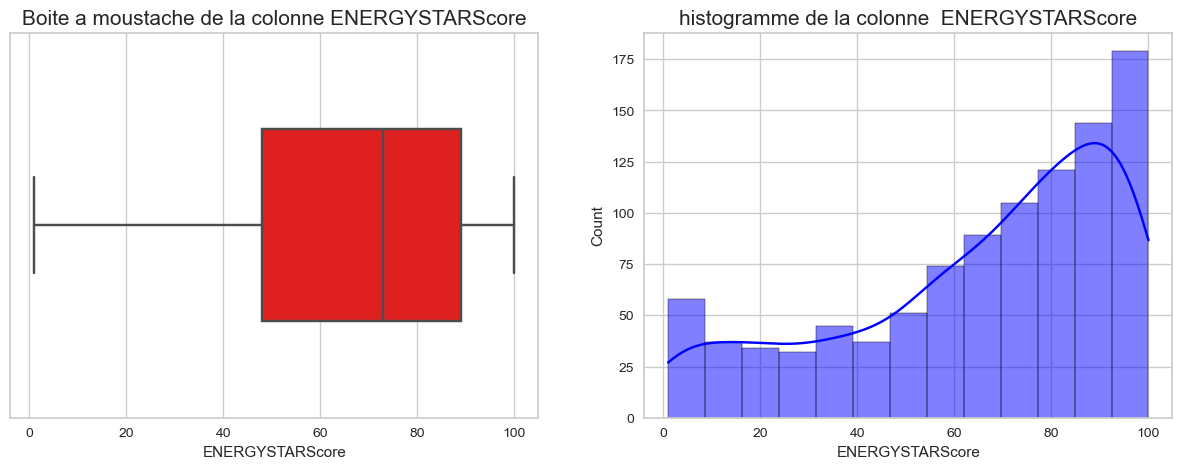

******************************************************************************************************************************************************
Analyse de la colonne SiteEUI_kBtu_sf
moyenne : 65.38
mediane : 49.75
mode : 0    30.9
1    35.0
Name: SiteEUI_kBtu_sf, dtype: float64
variance : 3204.26
skewness : 2.41
kurtosis : 7.39
ecart type : 56.61
min : 0.7
25% : 32.15
50% : 49.75
75% : 76.98
max : 465.5
Interprétation
la distribution de la colonne SiteEUI_kBtu_sf est étalée à droite
la distribution de la colonne SiteEUI_kBtu_sf est moins aplatie que la distribution normale


<Figure size 800x550 with 0 Axes>

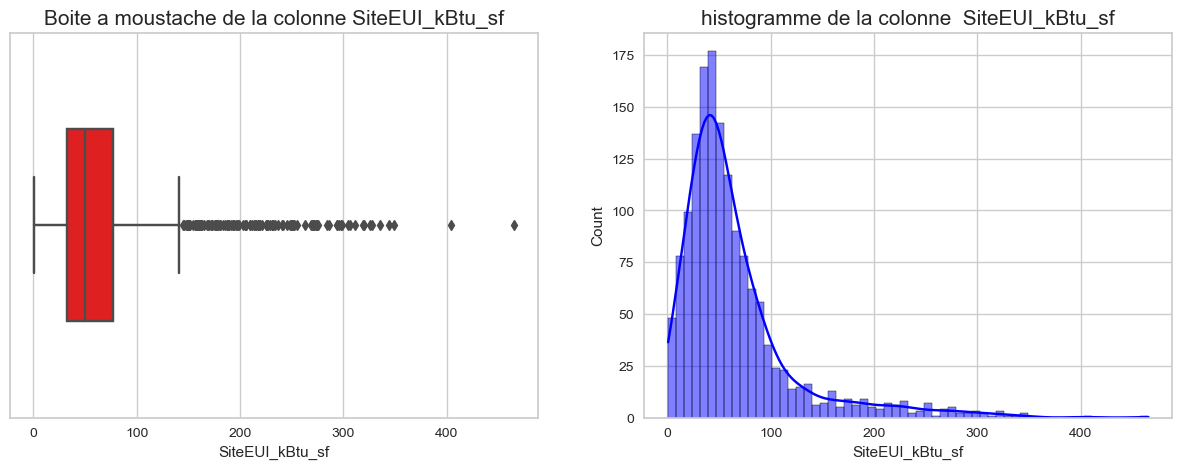

******************************************************************************************************************************************************
Analyse de la colonne SiteEnergyUse_kBtu
moyenne : 4692773.22
mediane : 2245532.25
mode : 0          16808.9
1          24105.5
2          44293.5
3          57133.2
4          72370.4
           ...    
1501    51168308.0
1502    52226204.0
1503    53466684.0
1504    62197176.0
1505    69519808.0
Name: SiteEnergyUse_kBtu, Length: 1506, dtype: float64
variance : 44055201010312.59
skewness : 3.74
kurtosis : 20.39
ecart type : 6637409.21
min : 16808.9
25% : 1164408.0
50% : 2245532.25
75% : 5398191.5
max : 69519808.0
Interprétation
la distribution de la colonne SiteEnergyUse_kBtu est étalée à droite
la distribution de la colonne SiteEnergyUse_kBtu est moins aplatie que la distribution normale


<Figure size 800x550 with 0 Axes>

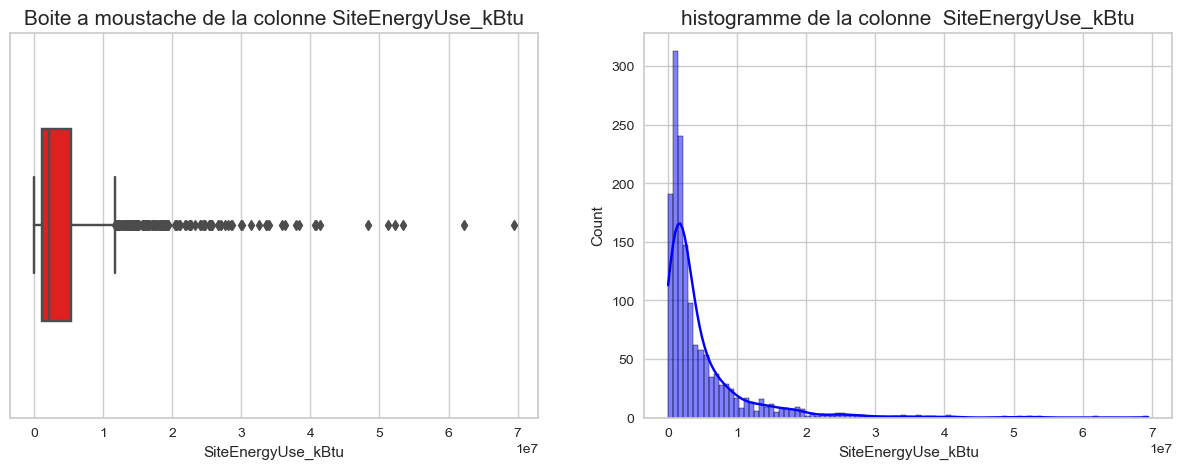

******************************************************************************************************************************************************
Analyse de la colonne SteamUse_kBtu
moyenne : 19835.19
mediane : 0.0
mode : 0    0.0
Name: SteamUse_kBtu, dtype: float64
variance : 17487115102.85
skewness : 7.75
kurtosis : 64.96
ecart type : 132238.86
min : 0.0
25% : 0.0
50% : 0.0
75% : 0.0
max : 1530680.62
Interprétation
la distribution de la colonne SteamUse_kBtu est étalée à droite
la distribution de la colonne SteamUse_kBtu est moins aplatie que la distribution normale


<Figure size 800x550 with 0 Axes>

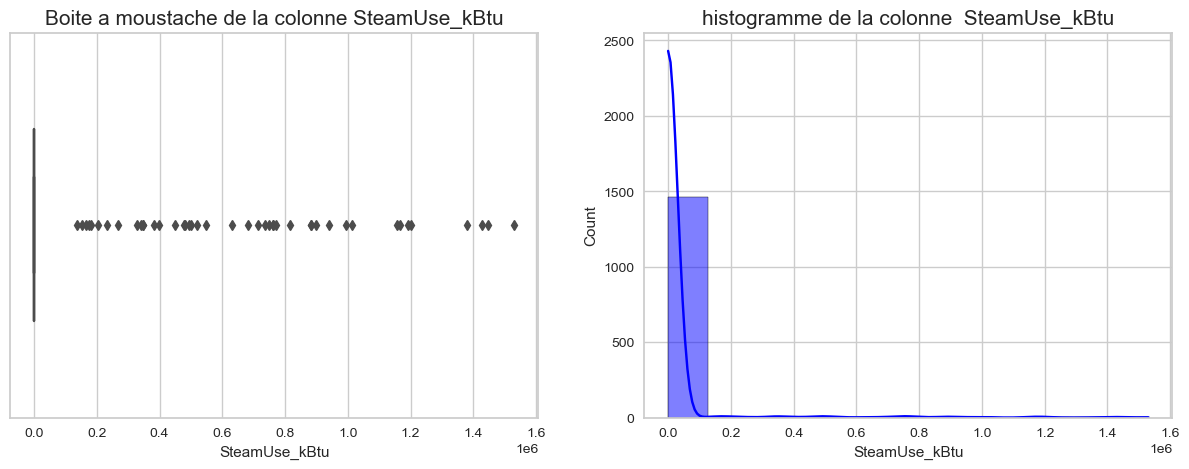

******************************************************************************************************************************************************
Analyse de la colonne TotalGHGEmissions
moyenne : 88.72
mediane : 44.3
mode : 0    6.3
Name: TotalGHGEmissions, dtype: float64
variance : 14935.61
skewness : 2.95
kurtosis : 10.87
ecart type : 122.21
min : 0.12
25% : 18.68
50% : 44.3
75% : 103.63
max : 866.23
Interprétation
la distribution de la colonne TotalGHGEmissions est étalée à droite
la distribution de la colonne TotalGHGEmissions est moins aplatie que la distribution normale


<Figure size 800x550 with 0 Axes>

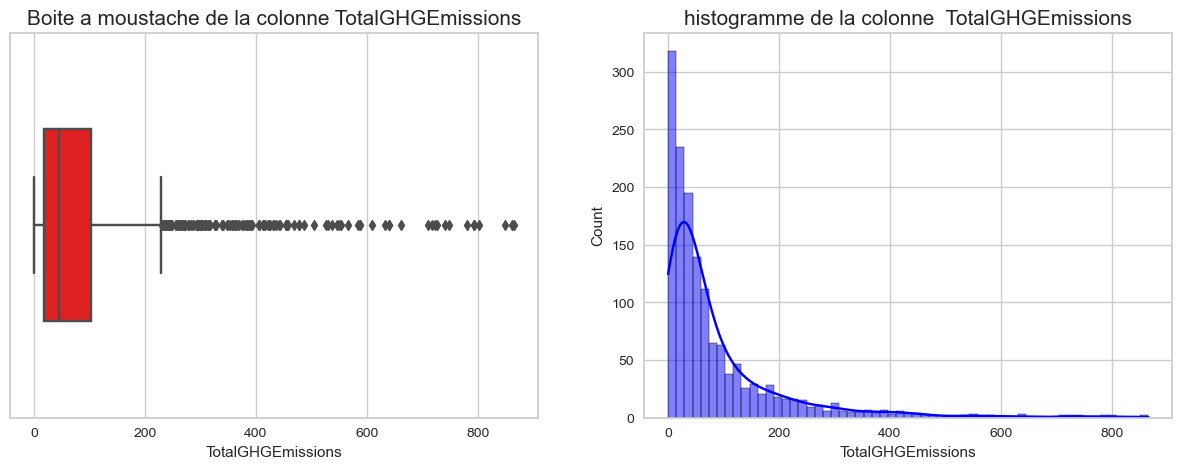

******************************************************************************************************************************************************
Analyse de la colonne GHGEmissionsIntensity
moyenne : 1.37
mediane : 0.81
mode : 0    0.23
Name: GHGEmissionsIntensity, dtype: float64
variance : 2.73
skewness : 2.8
kurtosis : 10.15
ecart type : 1.65
min : 0.0
25% : 0.34
50% : 0.81
75% : 1.72
max : 12.27
Interprétation
la distribution de la colonne GHGEmissionsIntensity est étalée à droite
la distribution de la colonne GHGEmissionsIntensity est moins aplatie que la distribution normale


<Figure size 800x550 with 0 Axes>

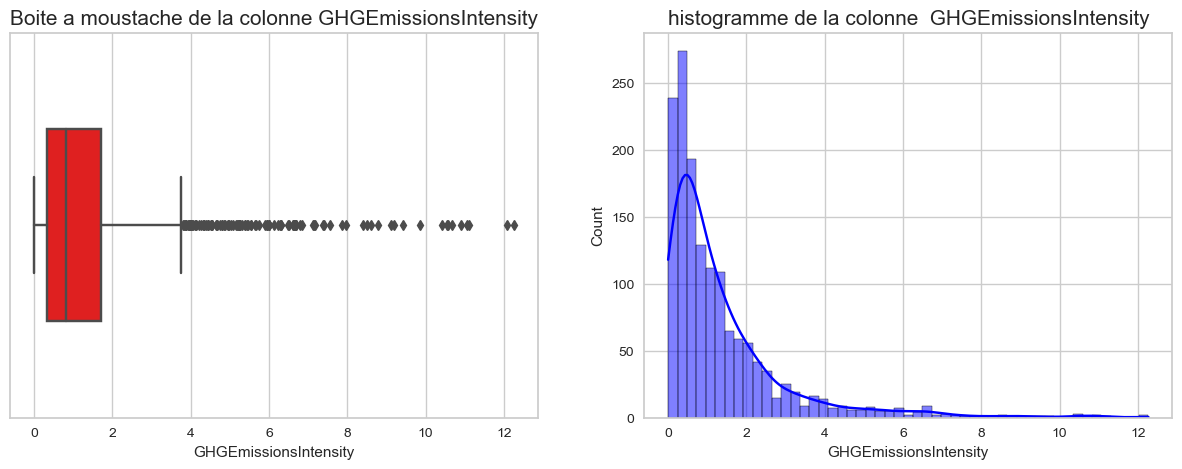

******************************************************************************************************************************************************
Analyse de la colonne Building_Age
moyenne : 54.81
mediane : 51.0
mode : 0    116
Name: Building_Age, dtype: int64
variance : 1064.31
skewness : 0.28
kurtosis : -1.04
ecart type : 32.62
min : 1
25% : 28.0
50% : 51.0
75% : 86.0
max : 116
Interprétation
la distribution de la colonne Building_Age est symétrique
la distribution de la colonne Building_Age est plus aplatie que la distribution normale


<Figure size 800x550 with 0 Axes>

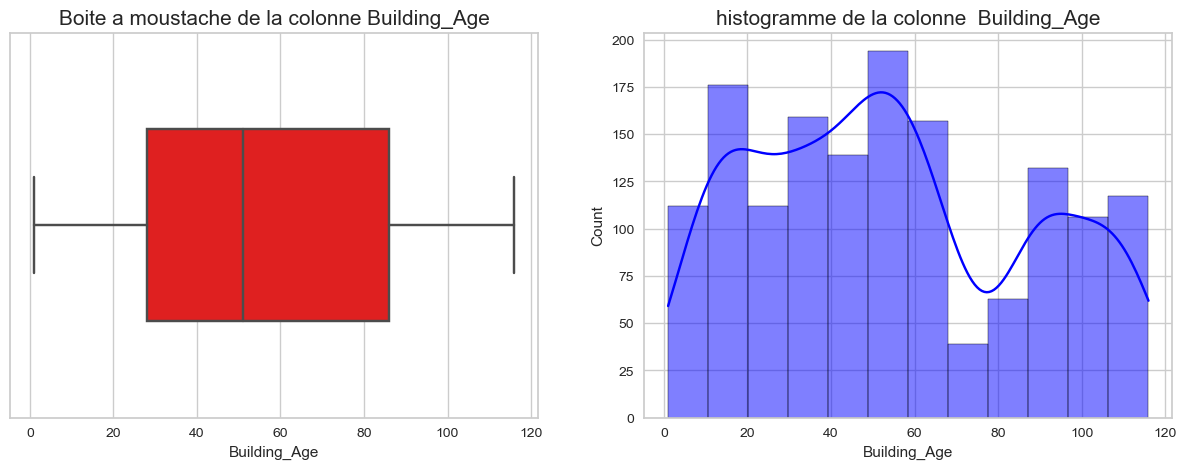

******************************************************************************************************************************************************


<Figure size 800x550 with 0 Axes>

In [71]:
for colonne in colonnes_numeriques:
    print(colored(150*'*', 'blue', attrs=['bold']))
    print(colored('Analyse de la colonne '+colonne, 'red', attrs=['bold']))
    analyse_univariee(data,colonne,str(colonne))
    #fichier ='univarie_'+colonne+'.png'
    #plt.savefig(fichier)
print(colored(150*'*', 'blue', attrs=['bold']))

# 6.  Analyse multivariée

In [72]:
def matrice_correlation(data,colonnes_a_analyser):
  plt.rcParams["figure.figsize"]=[15,7]
  data = data[colonnes_a_analyser]
  mask = np.triu(np.ones_like(data.corr(), dtype=bool))
  sns.heatmap(data.corr(), vmin=-1, vmax=1,annot=True,fmt = ".2f",mask=mask)
  plt.title('matrice de corrélation entre les colonnes ')
  fichier ='heatmap_fr'+'.png'
  plt.savefig(fichier)
  plt.show()

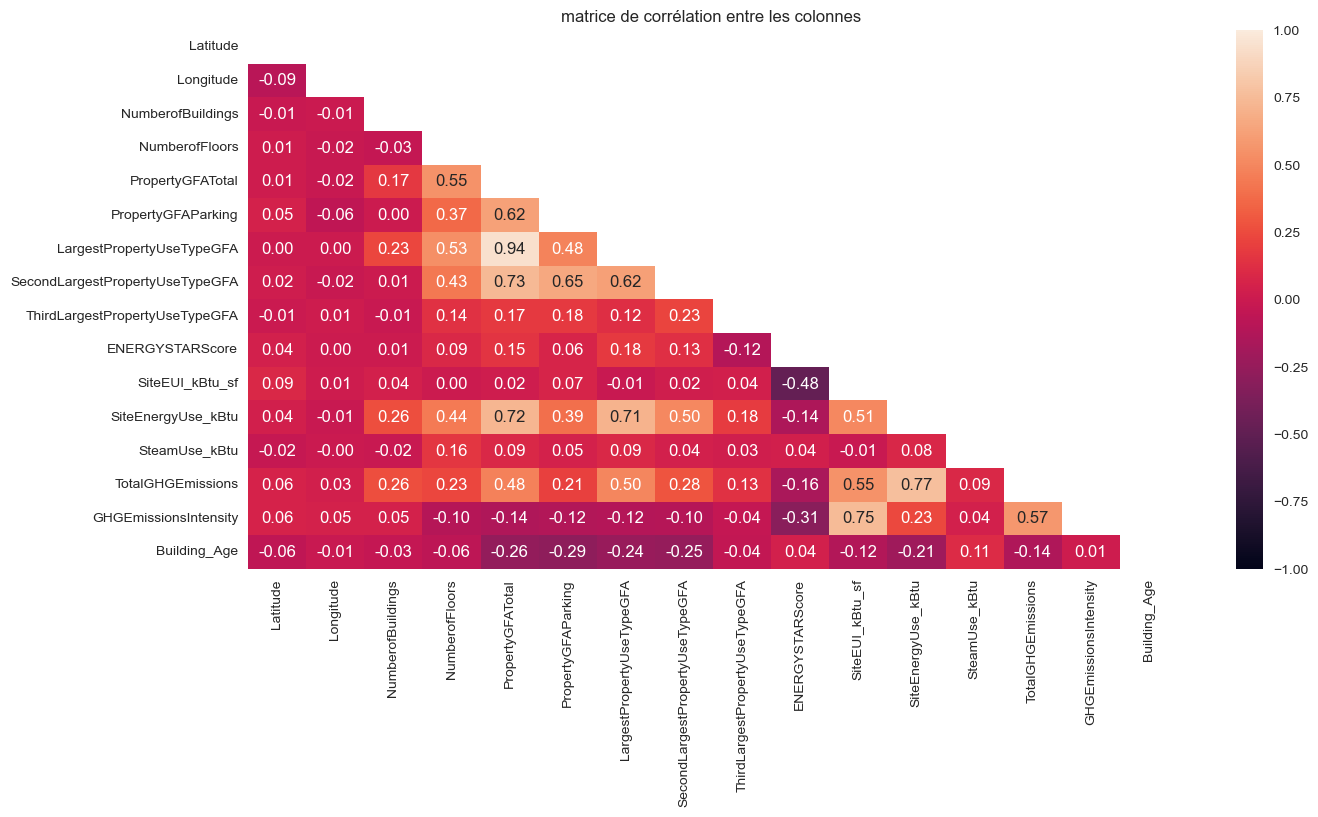

In [73]:
colonnes_numeriques= data.select_dtypes(include=[np.number]).columns.tolist()
matrice_correlation(data,colonnes_numeriques)

D'après la matrice de corrélation, nous remarquons :


Forte corrélation entre  LargestPropertyUseTypeGFA et PropertyGFATotal

Forte corrélation entre  SecondLargestPropertyUseTypeGFA et  PropertyGFATotal

Forte corrélation entre  SiteEnergyUse_kBtu et PropertyGFATotal

Forte corrélation entre SiteEnergyUse_kBtu et LargestPropertyUseTypeGFA

Forte corrélation entre SiteEnergyUse_kBtu et TotalGHGEmissions

Forte corrélation entre SiteEUI_kBtu_sf et GHGEmissionsIntensity


Il faut supprimer l'une de ces variables ou en créer des nouvelles 

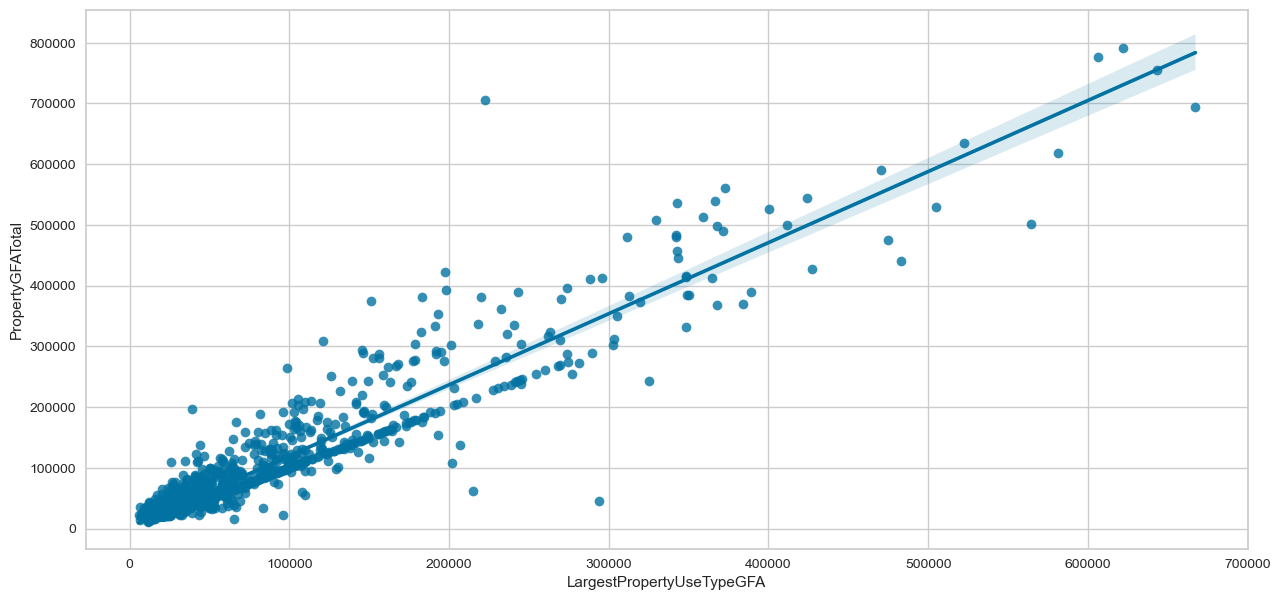

In [74]:
# Vérification d'un exemple de corrélation à  l'aide d'un shéma
sns.regplot(data=data, x='LargestPropertyUseTypeGFA', y='PropertyGFATotal')
plt.show()

# 7.  Feature engineering

## Transformation des variables

In [75]:
# Déviser quelques colonnes par la surface
def poucentage_surface(data,new_colonne,old_colonne,colonne_surface):
  data[new_colonne] = data[old_colonne]/data[colonne_surface]
  data = data.drop(old_colonne,1)

In [76]:
colonnes_pourcentage = {'Rate_Parking':'PropertyGFAParking',
                        'Rate_LargestPropertyUseType':'LargestPropertyUseTypeGFA',
                        'Rate_SecondLargestPropertyUseType':'SecondLargestPropertyUseTypeGFA',
                        'Rate_ThirdLargestPropertyUseType':'ThirdLargestPropertyUseTypeGFA'}

colonne_surface =  'PropertyGFATotal'  

for new_colonne,old_colonne in colonnes_pourcentage.items():
  print(new_colonne,'<<-------',old_colonne)
  poucentage_surface(data,new_colonne,old_colonne,colonne_surface)



Rate_Parking <<------- PropertyGFAParking
Rate_LargestPropertyUseType <<------- LargestPropertyUseTypeGFA
Rate_SecondLargestPropertyUseType <<------- SecondLargestPropertyUseTypeGFA
Rate_ThirdLargestPropertyUseType <<------- ThirdLargestPropertyUseTypeGFA


In [ ]:
# Vérifier la corrélation après cette transformation
dataaa = data.copy()
dataaa = dataaa.drop(['PropertyGFAParking','LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA'], 1)
colonnes_numeriques= dataaa.select_dtypes(include=[np.number]).columns.tolist()
matrice_correlation(dataaa,colonnes_numeriques)


Nous remarquons après cette transformation que la majorité des corrélations ont été supprimées. Il reste 3 corrélations. On va les revoir dans la partie features importance

 ## One-hot encoding

Le one hot encoding est la méthode la plus populaire pour transformer une variable catégorique en variable numérique. Sa popularité réside principalement dans la facilité d’application. De plus, pour beaucoup de problèmes, elle donne de bons résultats. Son principe est le suivant :

Considérons une variable catégorique X qui admet K modalités m1, m2, …, mK. Le one hot encoding consiste à créer K variables indicatrices, soit un vecteur de taille K qui a des 0 partout et un 1 à la position i correspondant à la modalité mi. On remplace donc la variable catégorique par K variables numériques.

In [ ]:
def encodage_categorielle(data,colonne):
  df_encodage=pd.get_dummies(data[colonne],prefix=colonne)
  return (df_encodage)


In [ ]:
colonnes_categoriques = data.select_dtypes('object').columns
data_encodage_categorielle = pd.DataFrame(index=data.index)
for colonne in colonnes_categoriques:
  df_encodage = encodage_categorielle(data,colonne)
  data_encodage_categorielle = pd.concat([data_encodage_categorielle,df_encodage],axis=1)



In [ ]:
data.shape

In [ ]:
data = data.drop(colonnes_categoriques,1)

In [ ]:
data = pd.concat([data,data_encodage_categorielle],axis=1)


In [ ]:
# remplacer les caracteres '(','/' par '_' dans les noms de colonnes
data.columns = data.columns.str.replace("[ /-]", "_")


In [ ]:
data.shape

# 8.  Features Importance


**Target 1 SiteEnergyUse_kBtu**

In [ ]:
data = data.astype(float)

In [ ]:
dataa=data.copy()

In [ ]:
# Supprimer la variable EnergystarScore parce qu'elle contient plusieurs valeurs manquantes et la variable target 2
data = data.drop(['ENERGYSTARScore','TotalGHGEmissions'],1)


In [ ]:
data = data.drop(['SiteEUI_kBtu_sf', 'SteamUse_kBtu',  'GHGEmissionsIntensity'],1)


In [ ]:
def features_importance(data,target):
  X = data.copy()
  X = X.drop(target, 1)
  y = data[target]  
  plt.figure(figsize=[10, 10])
  rf_model = RandomForestRegressor( n_jobs=-1,random_state=0,n_estimators=10)
  viz = FeatureImportances(rf_model, relative=True,topn=20)
  #viz.fit(X.iloc[:,0:15], y)
  viz.fit(X, y)

In [ ]:
features_importance(data,'SiteEnergyUse_kBtu')

Il s'avère que les colonnes  'LargestPropertyUseTypeGFA' et 'PropertyGFATotal'  sont  importants pour notre modèle de prédiction du target 1. On peut les garder 

In [ ]:
data1 = dataa.copy()
colonnes_numeriques1 =colonnes_numeriques.copy()

In [ ]:
data1 = data1.drop(['SiteEUI_kBtu_sf', 'SteamUse_kBtu', 'TotalGHGEmissions'],1)



In [ ]:
for elem in ['SiteEUI_kBtu_sf', 'SteamUse_kBtu', 'TotalGHGEmissions']:
    colonnes_numeriques1.remove(elem)

In [ ]:
# Vérifier les corrélations après la suppressions de quelques variables
matrice_correlation(data1,colonnes_numeriques1)

**Target 2 TotalGHGEmissions**

In [ ]:
data = dataa.copy()

In [ ]:
# Supprimer la variable EnergystarScore parce qu'elle contient plusieurs valeurs manquantes et la variable target 1
data = data.drop(['ENERGYSTARScore','SiteEnergyUse_kBtu','GHGEmissionsIntensity'],1)

In [ ]:
features_importance(data,'TotalGHGEmissions')

Il s'avère que les colonnes   'LargestPropertyUseTypeGFA' et 'PropertyGFATotal'  sont  importantes pour notre modèle de prédiction du target 2. On peut les garder. 
On peut supprimer la colonne 'GHGEmissionsIntensity', puisque elle représente des valeurs qu'on veut prédire. 


In [ ]:
data2 = dataa.copy()
colonnes_numeriques2 =colonnes_numeriques.copy()

In [ ]:
data2 = data2.drop(['GHGEmissionsIntensity','SiteEnergyUse_kBtu'],1)

In [ ]:
for elem in ['GHGEmissionsIntensity','SiteEnergyUse_kBtu']:
    colonnes_numeriques2.remove(elem)

In [ ]:
# Vérifier les corrélations après la suppressions de quelques variables
matrice_correlation(data2,colonnes_numeriques2)

# 9.  Sauvegarde du jeu de données après nettoyage

In [ ]:
data1.shape

In [ ]:
data2.shape

In [ ]:
data1.to_csv('data_energy_nettoye.csv', encoding='utf_8',index=False)

In [ ]:
data2.to_csv('data_gaz_nettoye.csv', encoding='utf_8',index=False)